## Commodity Price Predictions
Objective: to predict futures prices of commodities using a neural network by looking at time series data from the past

In [128]:
#package import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
import plotly.offline as py
import plotly.graph_objs as go
import keras_tuner as kt
import tensorflow as tf
from IPython.display import SVG
import os
import datetime, time
from tensorflow import keras
import tensorflow as tf
import random
from keras import backend as K
from keras.models import model_from_json
from keras.models import load_model
from keras.regularizers import L1L2

In [7]:
#load in data/take a look
df=pd.read_csv("commodities_12_22.csv")

df.head()

Date  Crude Oil  Brent Oil  Natural Gas    Gold  Silver  Copper
0  2022-06-15     119.11     121.35        7.296  1814.8  21.090  4.1777
1  2022-06-14     118.93     121.17        7.189  1813.5  20.954  4.1565
2  2022-06-13     120.93     122.27        8.609  1831.8  21.255  4.2115
3  2022-06-10     120.67     122.01        8.850  1875.5  21.931  4.2945
4  2022-06-09     121.51     123.07        8.963  1852.8  21.817  4.3810

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3259 entries, 0 to 3258
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         3259 non-null   object 
 1   Crude Oil    2734 non-null   float64
 2   Brent Oil    2701 non-null   float64
 3   Natural Gas  2733 non-null   float64
 4   Gold         2742 non-null   float64
 5   Silver       3256 non-null   float64
 6   Copper       2686 non-null   float64
dtypes: float64(6), object(1)
memory usage: 178.4+ KB


In [15]:
df.describe().T

count         mean         std       min         25%       50%  \
Crude Oil    2734.0    65.696774   22.436471    26.210    50.10000    55.280   
Brent Oil    2701.0    73.710655   26.026078    19.330    52.37000    66.550   
Natural Gas  2733.0     3.174109    1.058706     1.482     2.58200     2.912   
Gold         2742.0  1452.908888  252.226159  1049.700  1256.15000  1337.250   
Silver       3256.0    20.324379    5.321043    11.772    16.31975    18.071   
Copper       2686.0     3.126402    0.639881     1.994     2.68800     3.050   

                   75%        max  
Crude Oil      90.0325   122.1100  
Brent Oil     103.4600   127.9800  
Natural Gas     3.6490     9.3220  
Gold         1684.7500  2054.6000  
Silver         23.8970    37.1400  
Copper          3.4350     4.9125

In [19]:
df.dtypes

Date            object
Crude Oil      float64
Brent Oil      float64
Natural Gas    float64
Gold           float64
Silver         float64
Copper         float64
dtype: object

In [21]:
#Flip the df to put the dates in chronological order
df=df.iloc[::-1]

df.head()

Date  Crude Oil  Brent Oil  Natural Gas  Gold  Silver  Copper
3258  2012-01-02        NaN        NaN          NaN   NaN  28.160     NaN
3257  2012-01-08        NaN        NaN          NaN   NaN  28.848     NaN
3256  2012-01-15        NaN        NaN          NaN   NaN  29.785     NaN
3255  2012-01-22        NaN        NaN          NaN   NaN  31.793     NaN
3254  2012-01-29        NaN        NaN          NaN   NaN  33.908     NaN

In [23]:
#Date seperation
df[["Year", "Month", "Day"]] = df["Date"].str.split("-", expand = True)
df.head()

Date  Crude Oil  Brent Oil  Natural Gas  Gold  Silver  Copper  \
3258  2012-01-02        NaN        NaN          NaN   NaN  28.160     NaN   
3257  2012-01-08        NaN        NaN          NaN   NaN  28.848     NaN   
3256  2012-01-15        NaN        NaN          NaN   NaN  29.785     NaN   
3255  2012-01-22        NaN        NaN          NaN   NaN  31.793     NaN   
3254  2012-01-29        NaN        NaN          NaN   NaN  33.908     NaN   

      Year Month Day  
3258  2012    01  02  
3257  2012    01  08  
3256  2012    01  15  
3255  2012    01  22  
3254  2012    01  29

In [25]:
df_copy=df.copy()

In [27]:
da=["Month", "Day"]
for j,i in enumerate(da):
    col_date=df.pop(i)
    df.insert(j+2,i,col_date)
df.head()

Date  Crude Oil Month Day  Brent Oil  Natural Gas  Gold  Silver  \
3258  2012-01-02        NaN    01  02        NaN          NaN   NaN  28.160   
3257  2012-01-08        NaN    01  08        NaN          NaN   NaN  28.848   
3256  2012-01-15        NaN    01  15        NaN          NaN   NaN  29.785   
3255  2012-01-22        NaN    01  22        NaN          NaN   NaN  31.793   
3254  2012-01-29        NaN    01  29        NaN          NaN   NaN  33.908   

      Copper  Year  
3258     NaN  2012  
3257     NaN  2012  
3256     NaN  2012  
3255     NaN  2012  
3254     NaN  2012

In [29]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df

Date  Crude Oil Month Day  Brent Oil  Natural Gas    Gold  Silver  \
3258 2012-01-02        NaN    01  02        NaN          NaN     NaN  28.160   
3257 2012-01-08        NaN    01  08        NaN          NaN     NaN  28.848   
3256 2012-01-15        NaN    01  15        NaN          NaN     NaN  29.785   
3255 2012-01-22        NaN    01  22        NaN          NaN     NaN  31.793   
3254 2012-01-29        NaN    01  29        NaN          NaN     NaN  33.908   
...         ...        ...   ...  ..        ...          ...     ...     ...   
4    2022-06-09     121.51    06  09     123.07        8.963  1852.8  21.817   
3    2022-06-10     120.67    06  10     122.01        8.850  1875.5  21.931   
2    2022-06-13     120.93    06  13     122.27        8.609  1831.8  21.255   
1    2022-06-14     118.93    06  14     121.17        7.189  1813.5  20.954   
0    2022-06-15     119.11    06  15     121.35        7.296  1814.8  21.090   

      Copper  Year  
3258     NaN  2012  
3257     NaN  2012  
3256     NaN  2012  
3255     NaN  2012  
3254     NaN  2012  
...      ...   ...  
4     4.3810  2022  
3     4.2945  2022  
2     4.2115  2022  
1     4.1565  2022  
0     4.1777  2022  

[3259 rows x 10 columns]

## Plots

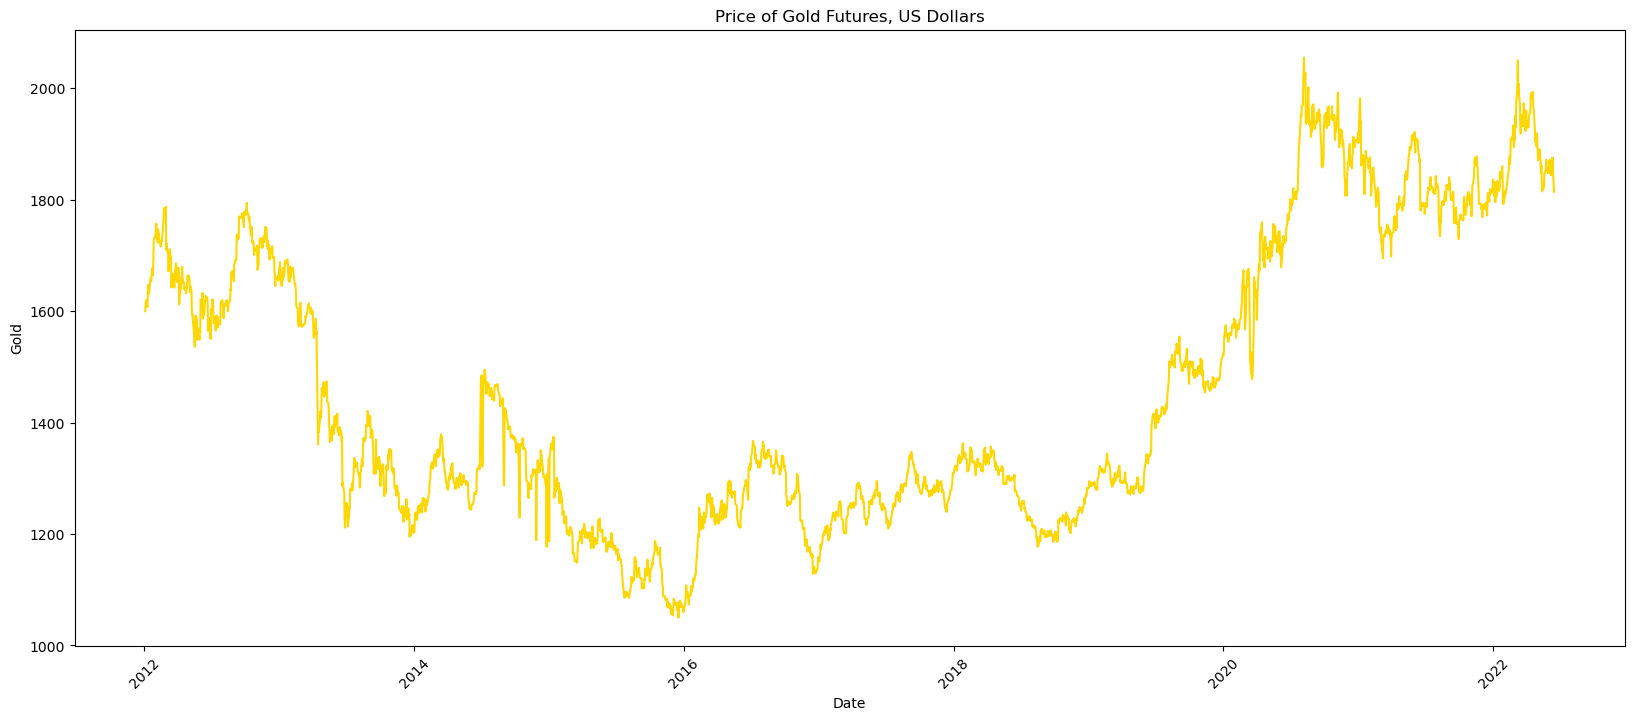

In [42]:
plt.rcParams["figure.figsize"] = (20,8)
sns.lineplot(data=df, x="Date", y="Gold", color='gold')
plt.xticks(rotation = 45) 
plt.title("Price of Gold Futures, US Dollars")
plt.show()

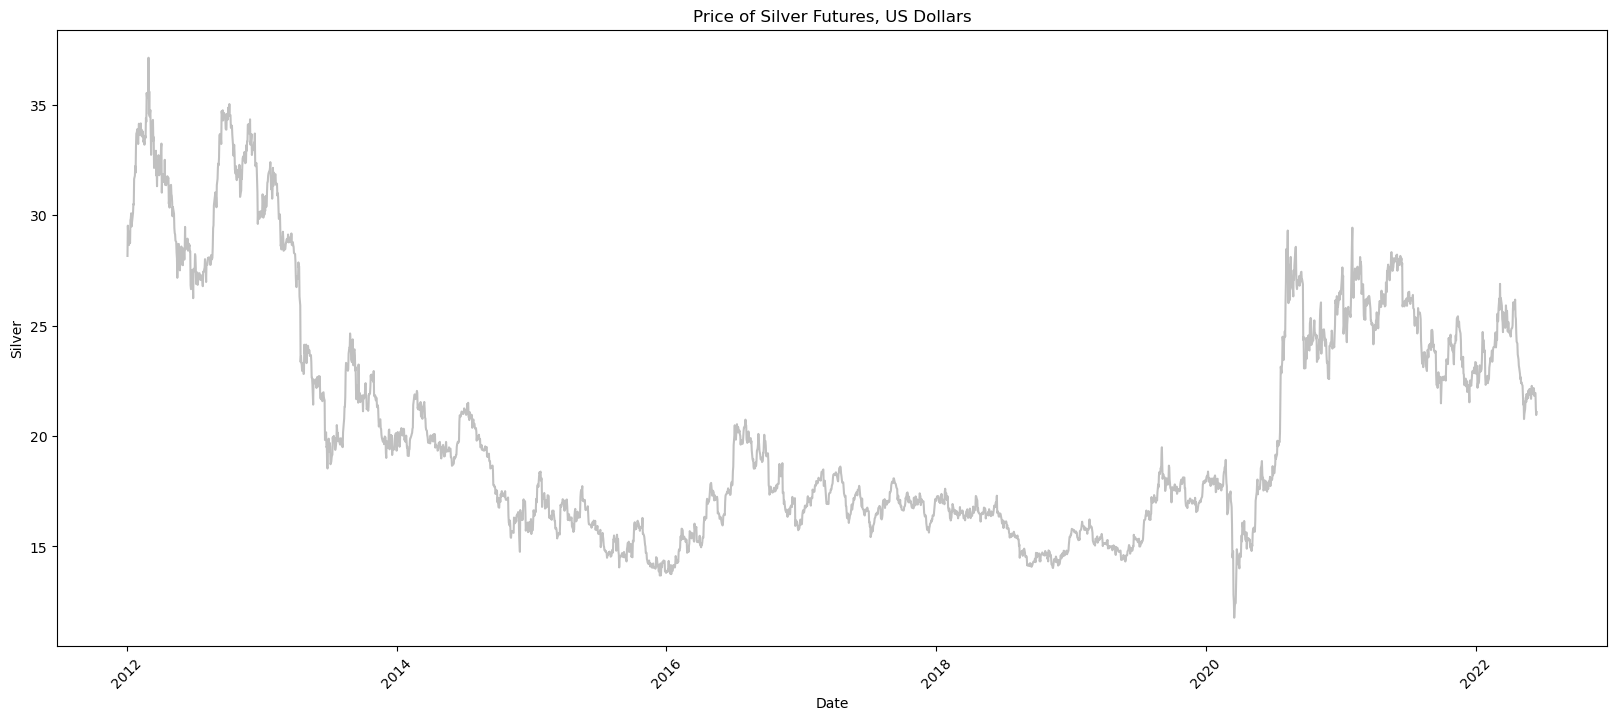

In [44]:
plt.rcParams["figure.figsize"] = (20,8)
sns.lineplot(data=df, x="Date", y="Silver", color='silver')
plt.xticks(rotation = 45) 
plt.title("Price of Silver Futures, US Dollars")
plt.show()

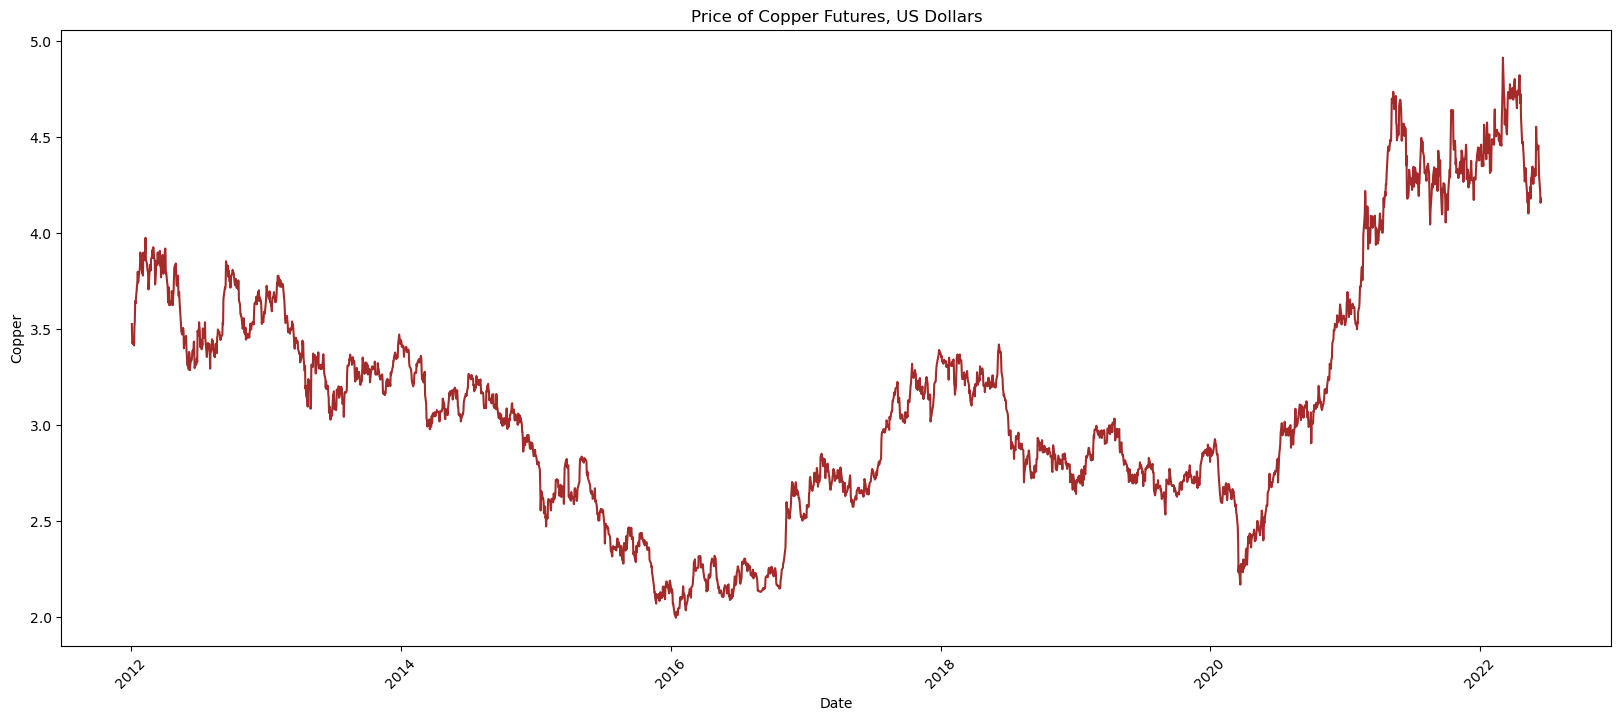

In [46]:
plt.rcParams["figure.figsize"] = (20,8)
sns.lineplot(data=df, x="Date", y="Copper",color='brown')
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
ax = plt.gca()
plt.title("Price of Copper Futures, US Dollars")
plt.show()

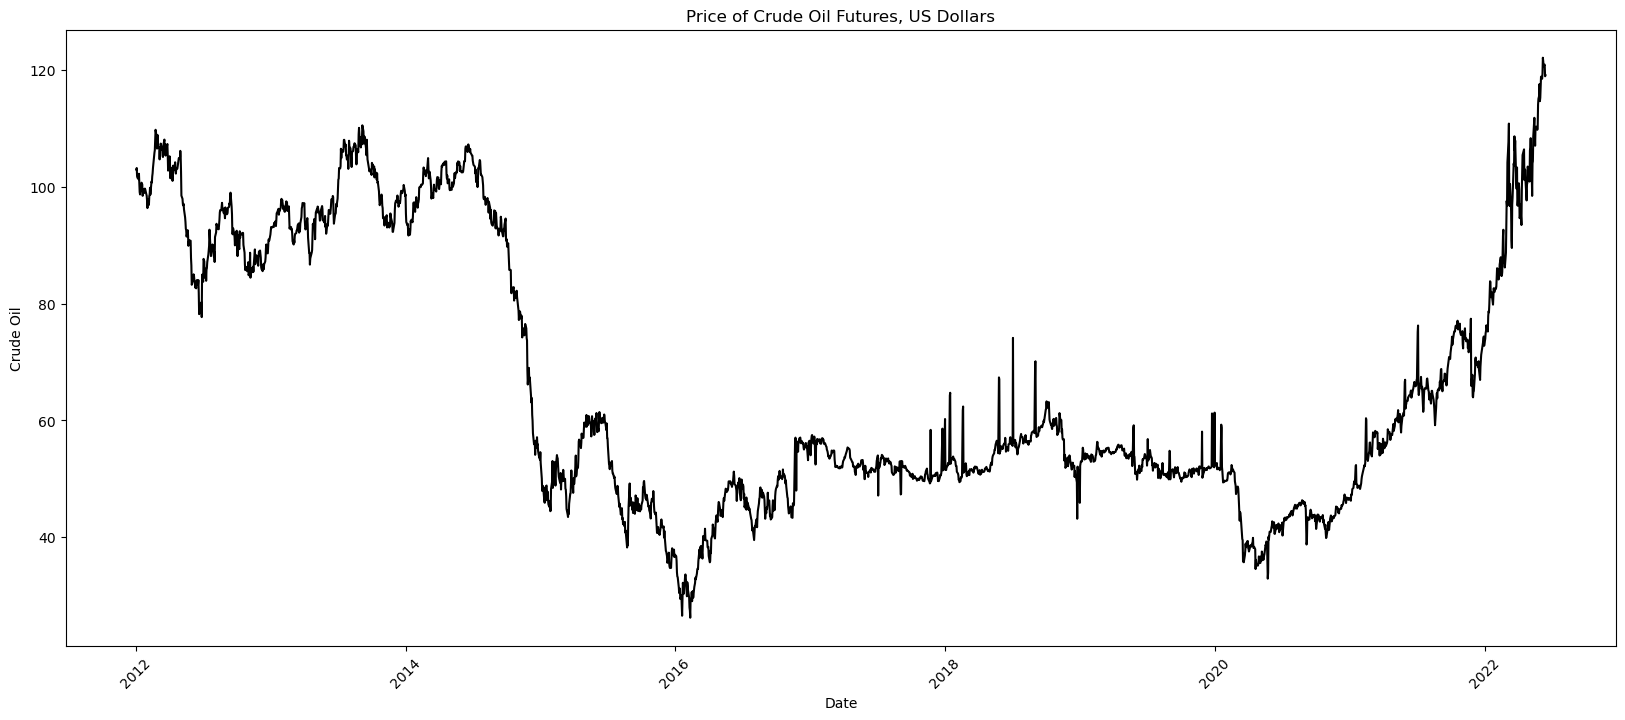

In [48]:
plt.rcParams["figure.figsize"] = (20,8)
sns.lineplot(data=df, x="Date", y="Crude Oil",color='black')
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
ax = plt.gca()
plt.title("Price of Crude Oil Futures, US Dollars")
plt.show()

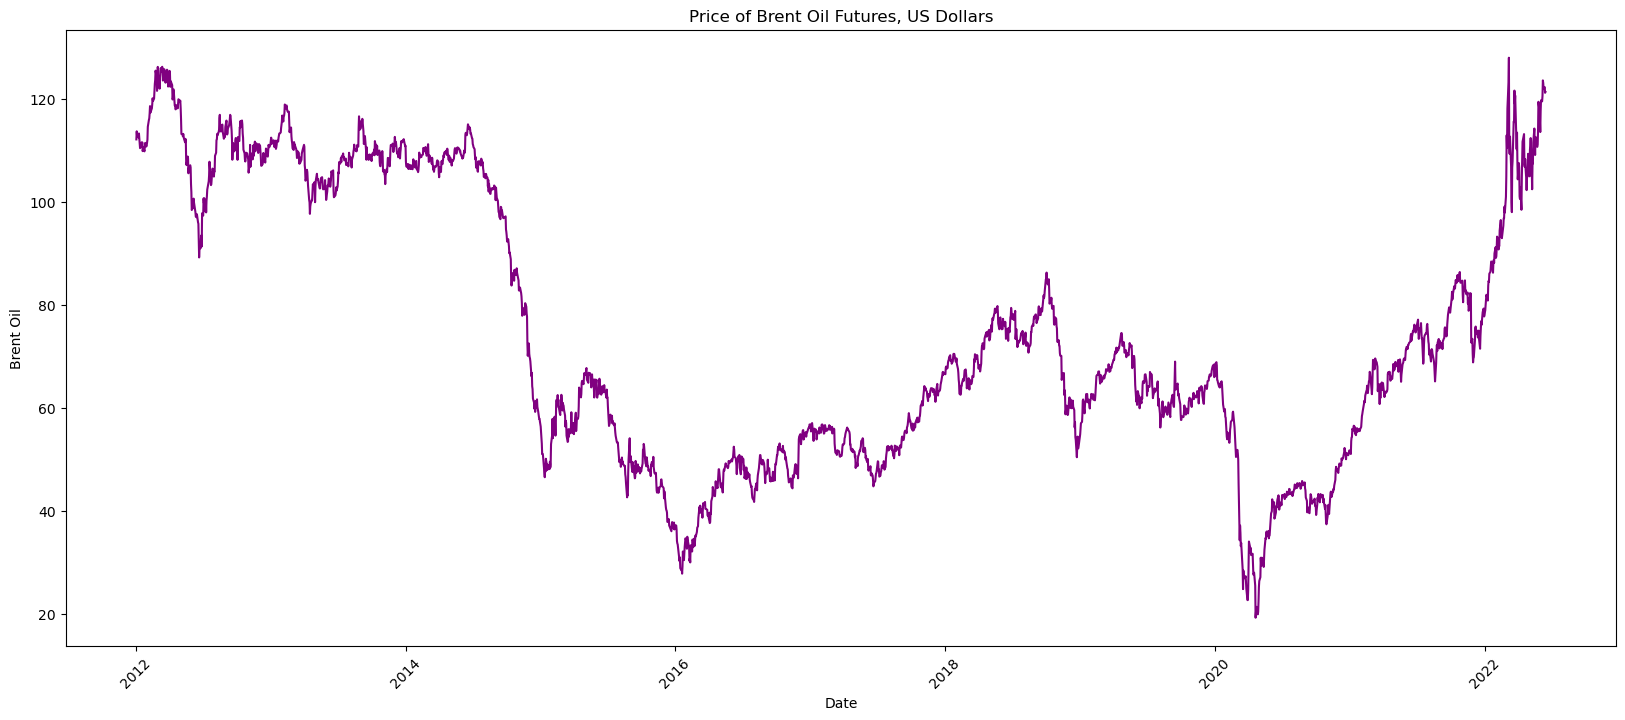

In [54]:
plt.rcParams["figure.figsize"] = (20,8)
sns.lineplot(data=df, x="Date", y="Brent Oil",color='purple')
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
ax = plt.gca()
plt.title("Price of Brent Oil Futures, US Dollars")
plt.show()

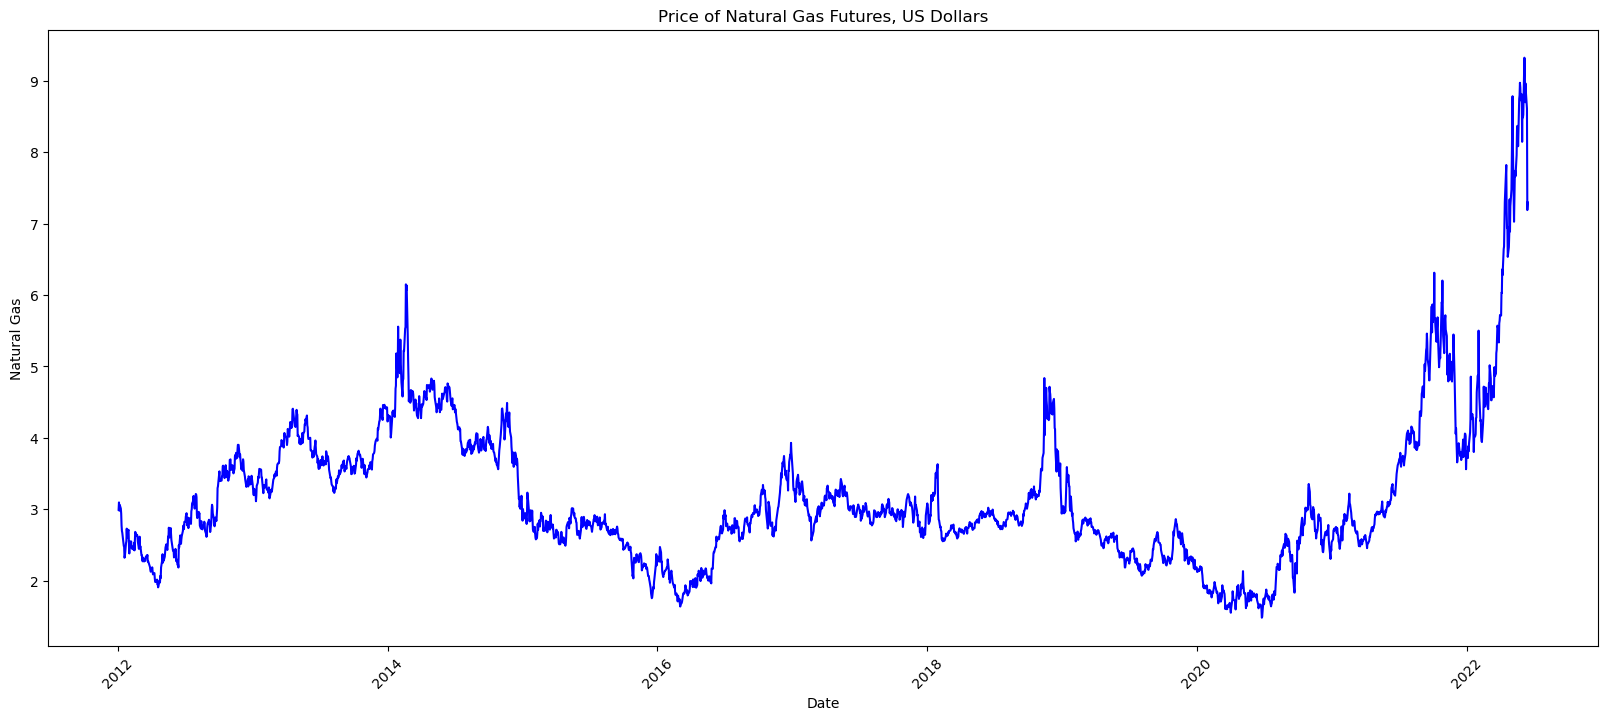

In [52]:
plt.rcParams["figure.figsize"] = (20,8)
sns.lineplot(data=df, x="Date", y="Natural Gas",color='blue')
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
ax = plt.gca()
plt.title("Price of Natural Gas Futures, US Dollars")
plt.show()

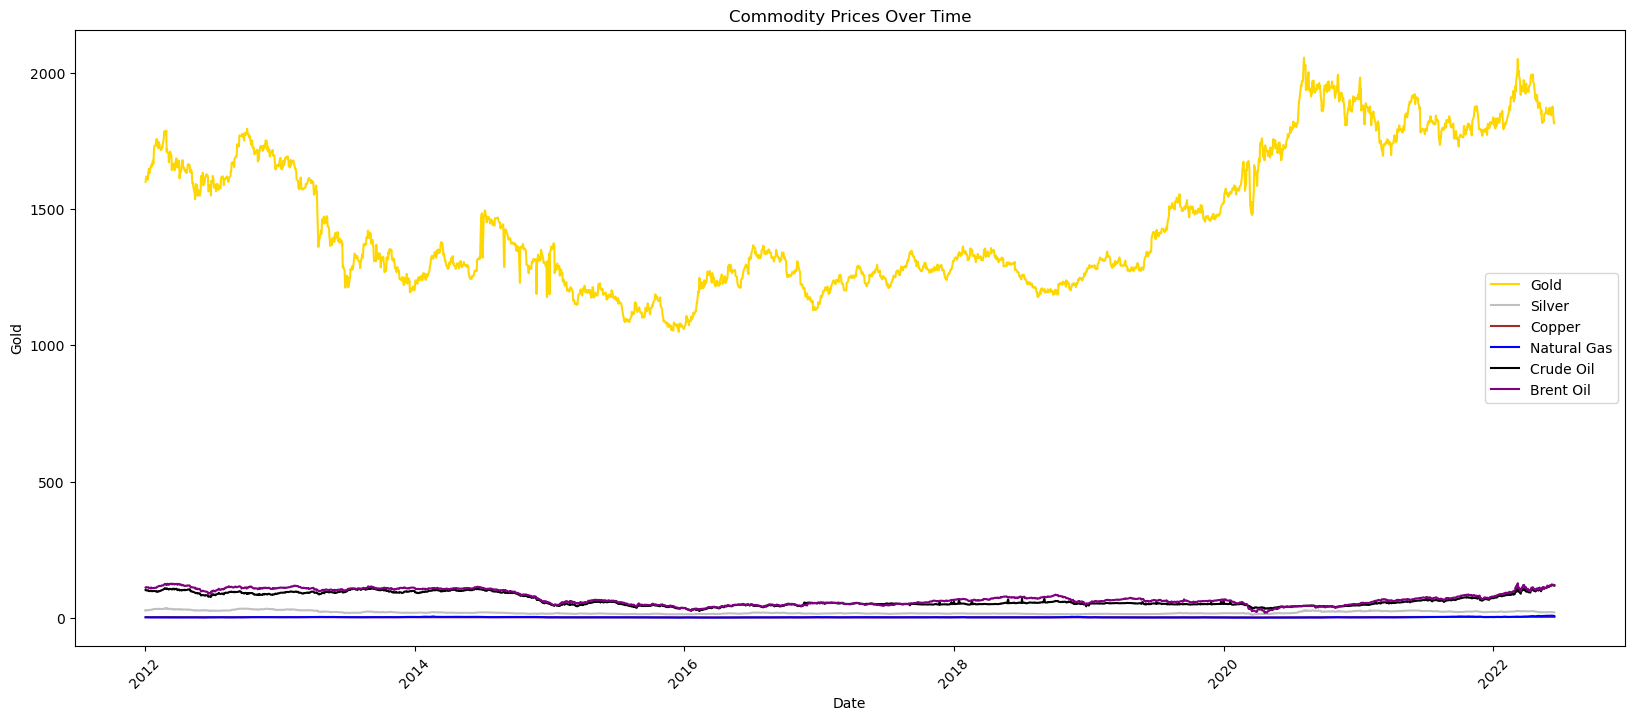

In [62]:
#Putting the graphs together
plt.rcParams["figure.figsize"] = (20,8)
ax = plt.gca() 
sns.lineplot(data=df, x="Date", y="Gold", color='gold', label='Gold', ax=ax)
sns.lineplot(data=df, x="Date", y="Silver", color='silver', label='Silver', ax=ax)
sns.lineplot(data=df, x="Date", y="Copper", color='brown', label='Copper', ax=ax)
sns.lineplot(data=df, x="Date", y="Natural Gas", color='blue', label='Natural Gas', ax=ax)
sns.lineplot(data=df, x="Date", y="Crude Oil", color='black', label='Crude Oil', ax=ax)
sns.lineplot(data=df, x="Date", y="Brent Oil", color='purple', label='Brent Oil', ax=ax)
plt.xticks(rotation=45)

plt.title('Commodity Prices Over Time')
plt.show()


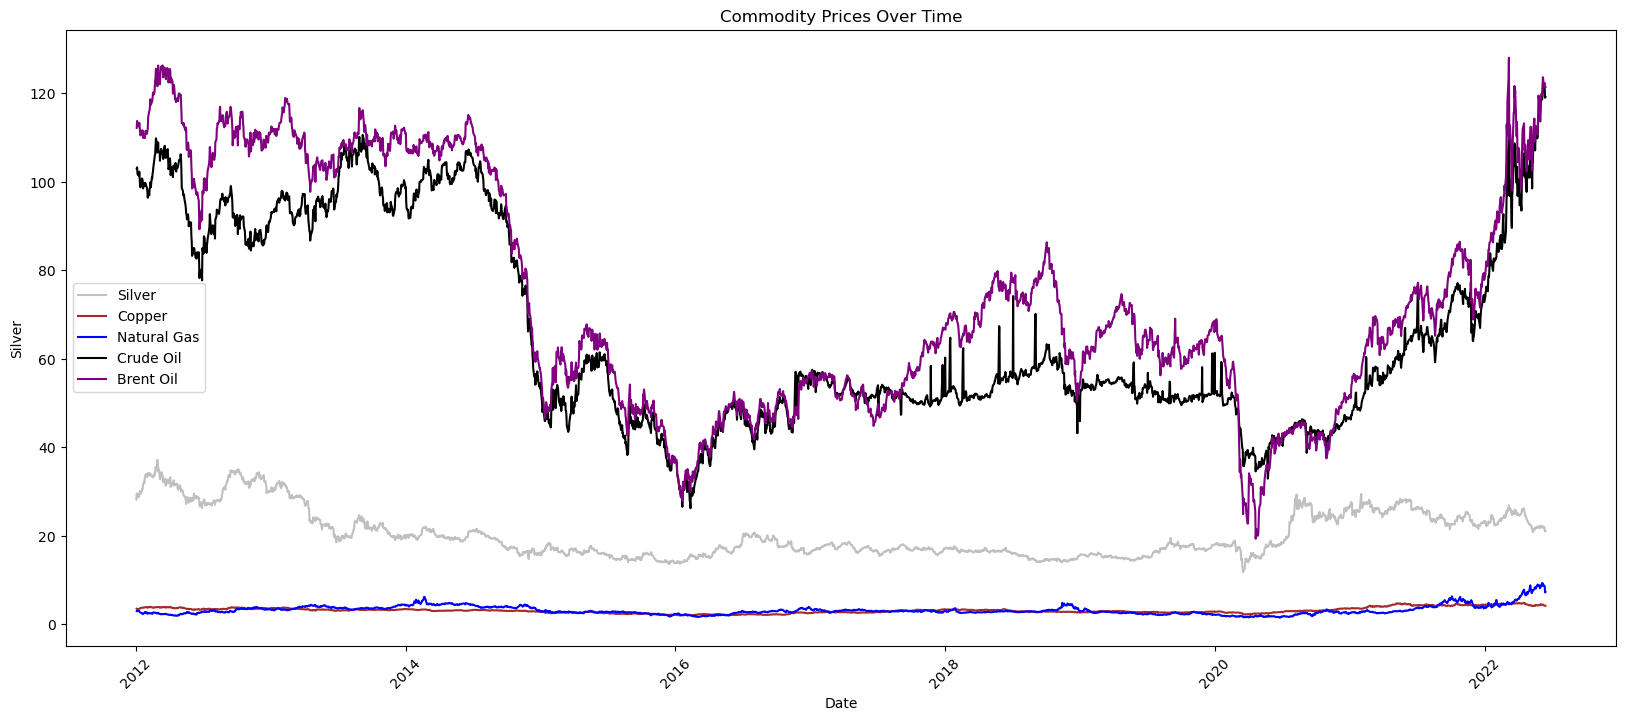

In [64]:
#Prices without gold
plt.rcParams["figure.figsize"] = (20,8)
ax = plt.gca() 
#sns.lineplot(data=df, x="Date", y="Gold", color='gold', label='Gold', ax=ax)
sns.lineplot(data=df, x="Date", y="Silver", color='silver', label='Silver', ax=ax)
sns.lineplot(data=df, x="Date", y="Copper", color='brown', label='Copper', ax=ax)
sns.lineplot(data=df, x="Date", y="Natural Gas", color='blue', label='Natural Gas', ax=ax)
sns.lineplot(data=df, x="Date", y="Crude Oil", color='black', label='Crude Oil', ax=ax)
sns.lineplot(data=df, x="Date", y="Brent Oil", color='purple', label='Brent Oil', ax=ax)
plt.xticks(rotation=45)

plt.title('Commodity Prices Over Time')
plt.show()

## Correlation Heatmap

In [69]:
df.corr()

Date  Crude Oil     Month       Day  Brent Oil  Natural Gas  \
Date         1.000000  -0.473347  0.024428  0.001564  -0.485077     0.067223   
Crude Oil   -0.473347   1.000000 -0.061113 -0.003706   0.967352     0.629670   
Month        0.024428  -0.061113  1.000000  0.005348  -0.066144     0.066446   
Day          0.001564  -0.003706  0.005348  1.000000  -0.005121    -0.000745   
Brent Oil   -0.485077   0.967352 -0.066144 -0.005121   1.000000     0.561949   
Natural Gas  0.067223   0.629670  0.066446 -0.000745   0.561949     1.000000   
Gold         0.426026   0.235434 -0.046895 -0.008826   0.218652     0.198904   
Silver      -0.225151   0.575061 -0.071106 -0.005145   0.599688     0.198497   
Copper       0.236297   0.576720 -0.080210 -0.004149   0.601358     0.559681   
Year         0.995448  -0.466205 -0.070633 -0.006881  -0.477770     0.060717   

                 Gold    Silver    Copper      Year  
Date         0.426026 -0.225151  0.236297  0.995448  
Crude Oil    0.235434  0.575061  0.576720 -0.466205  
Month       -0.046895 -0.071106 -0.080210 -0.070633  
Day         -0.008826 -0.005145 -0.004149 -0.006881  
Brent Oil    0.218652  0.599688  0.601358 -0.477770  
Natural Gas  0.198904  0.198497  0.559681  0.060717  
Gold         1.000000  0.734949  0.713134  0.429312  
Silver       0.734949  1.000000  0.688431 -0.218002  
Copper       0.713134  0.688431  1.000000  0.243268  
Year         0.429312 -0.218002  0.243268  1.000000

<Axes: >

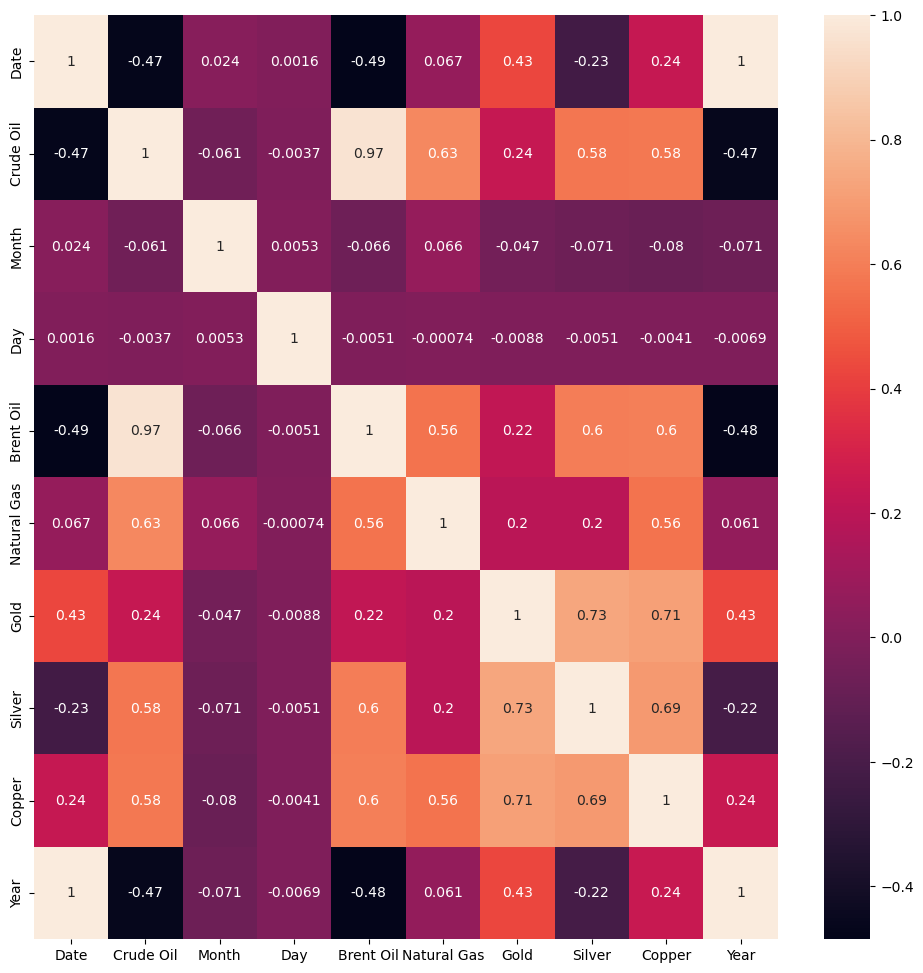

In [71]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(method='pearson'),cbar=True,annot=True)

### Strong Positive Correlations:
- Crude Oil and Brent Oil (0.97): Crude Oil and Brent Oil have a very high positive correlation, indicating that their prices move in tandem. This is expected since they are closely related energy commodities.
- Gold, Silver, and Copper:
    - Gold and Silver (0.73): These precious metals are highly correlated, likely due to similar factors influencing their prices, such as inflation and economic stability.
    - Gold and Copper (0.71): A strong correlation exists between Gold and Copper, potentially reflecting their shared dependence on economic trends (e.g., demand during growth periods).
    - Silver and Copper (0.69): Similar to Gold and Copper, this correlation highlights common market drivers for these metals.
 
### Moderate Correlations:
- Natural Gas with Crude Oil (0.63): Natural Gas and Crude Oil show a moderate positive correlation. This reflects their shared dependence on energy demand and supply factors but also highlights differences due to their unique market dynamics.
- Silver and Brent Oil (0.6): Silver has a moderate correlation with Brent Oil, possibly indicating that market conditions affecting energy and metals overlap to some extent (e.g., economic growth or inflation).
  
### Negative Correlations:
- Crude Oil and Date (-0.47): The negative correlation suggests that Crude Oil prices may have been decreasing over time in the dataset. This could reflect broader market trends like a move toward renewable energy or reduced demand during certain periods.
- Brent Oil and Date (-0.48): Similar to Crude Oil, Brent Oil shows a downward trend over time.

### Scatterplots

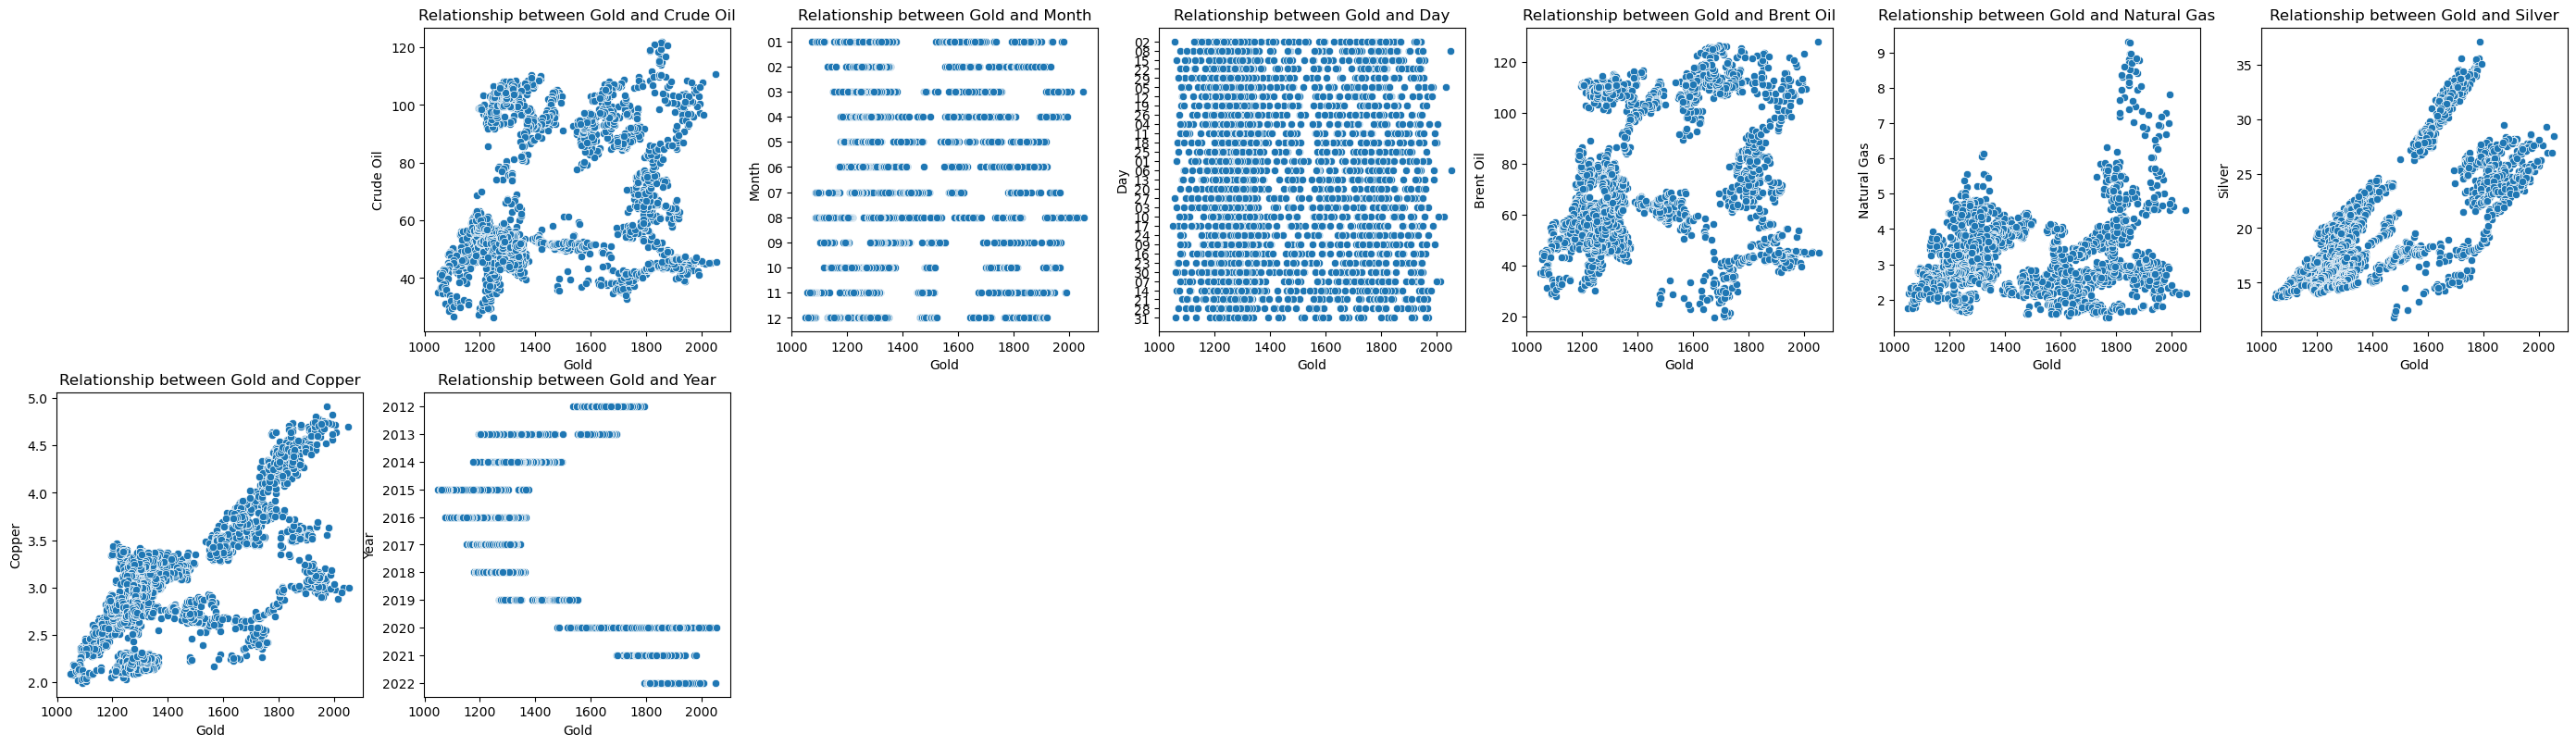

In [76]:
#Scatterplots
plt.figure(figsize=(35,35))
j=0

for i in enumerate(df): 
    if i[1]!="Gold" and i[1]!="Date":
        j+=1
#         print(i[0])
#         plt.figure(figsize=(10,10))
        plt.subplot(7,7,j+1)
        sns.scatterplot(y=df[i[1]],x=df["Gold"])
        plt.title('Relationship between Gold and '+str(i[1]))

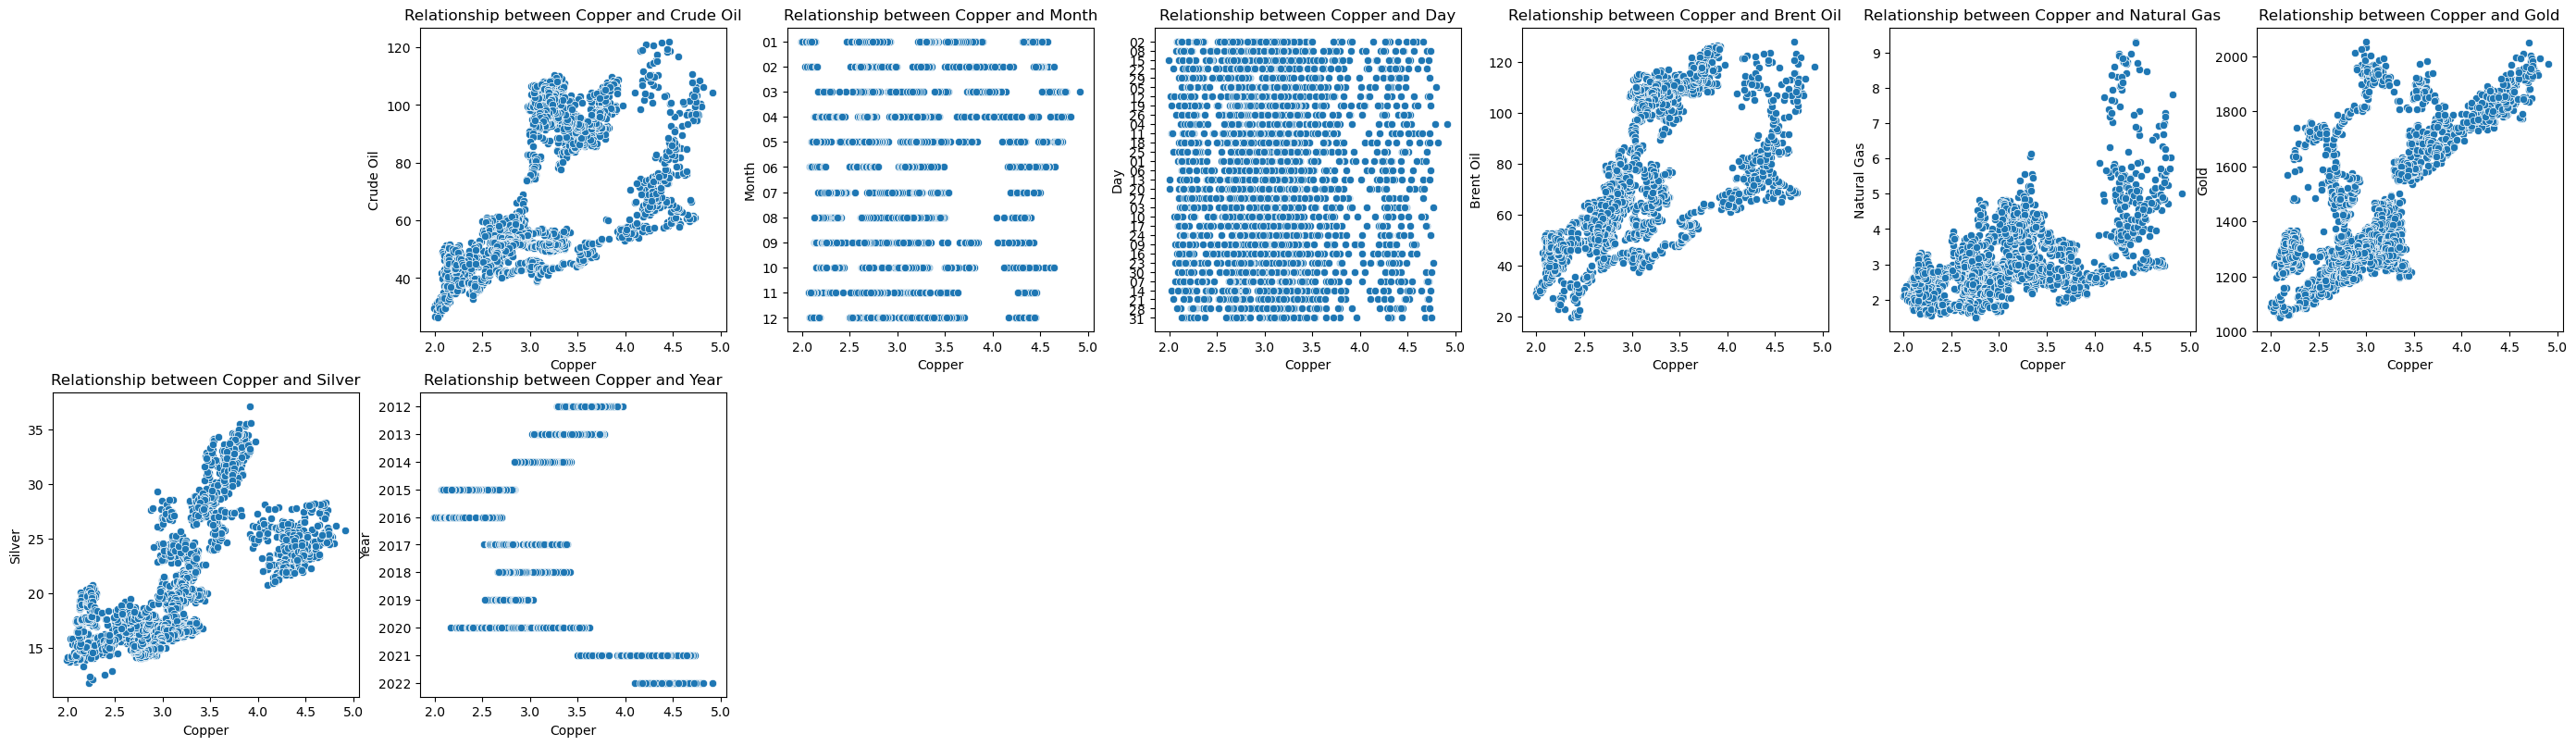

In [79]:
plt.figure(figsize=(35,35))
j=0

for i in enumerate(df): 
    if i[1]!="Copper" and i[1]!="Date":
        j+=1
#         print(i[0])
#         plt.figure(figsize=(10,10))
        plt.subplot(7,7,j+1)
        sns.scatterplot(y=df[i[1]],x=df["Copper"])
        plt.title('Relationship between Copper and '+str(i[1]))

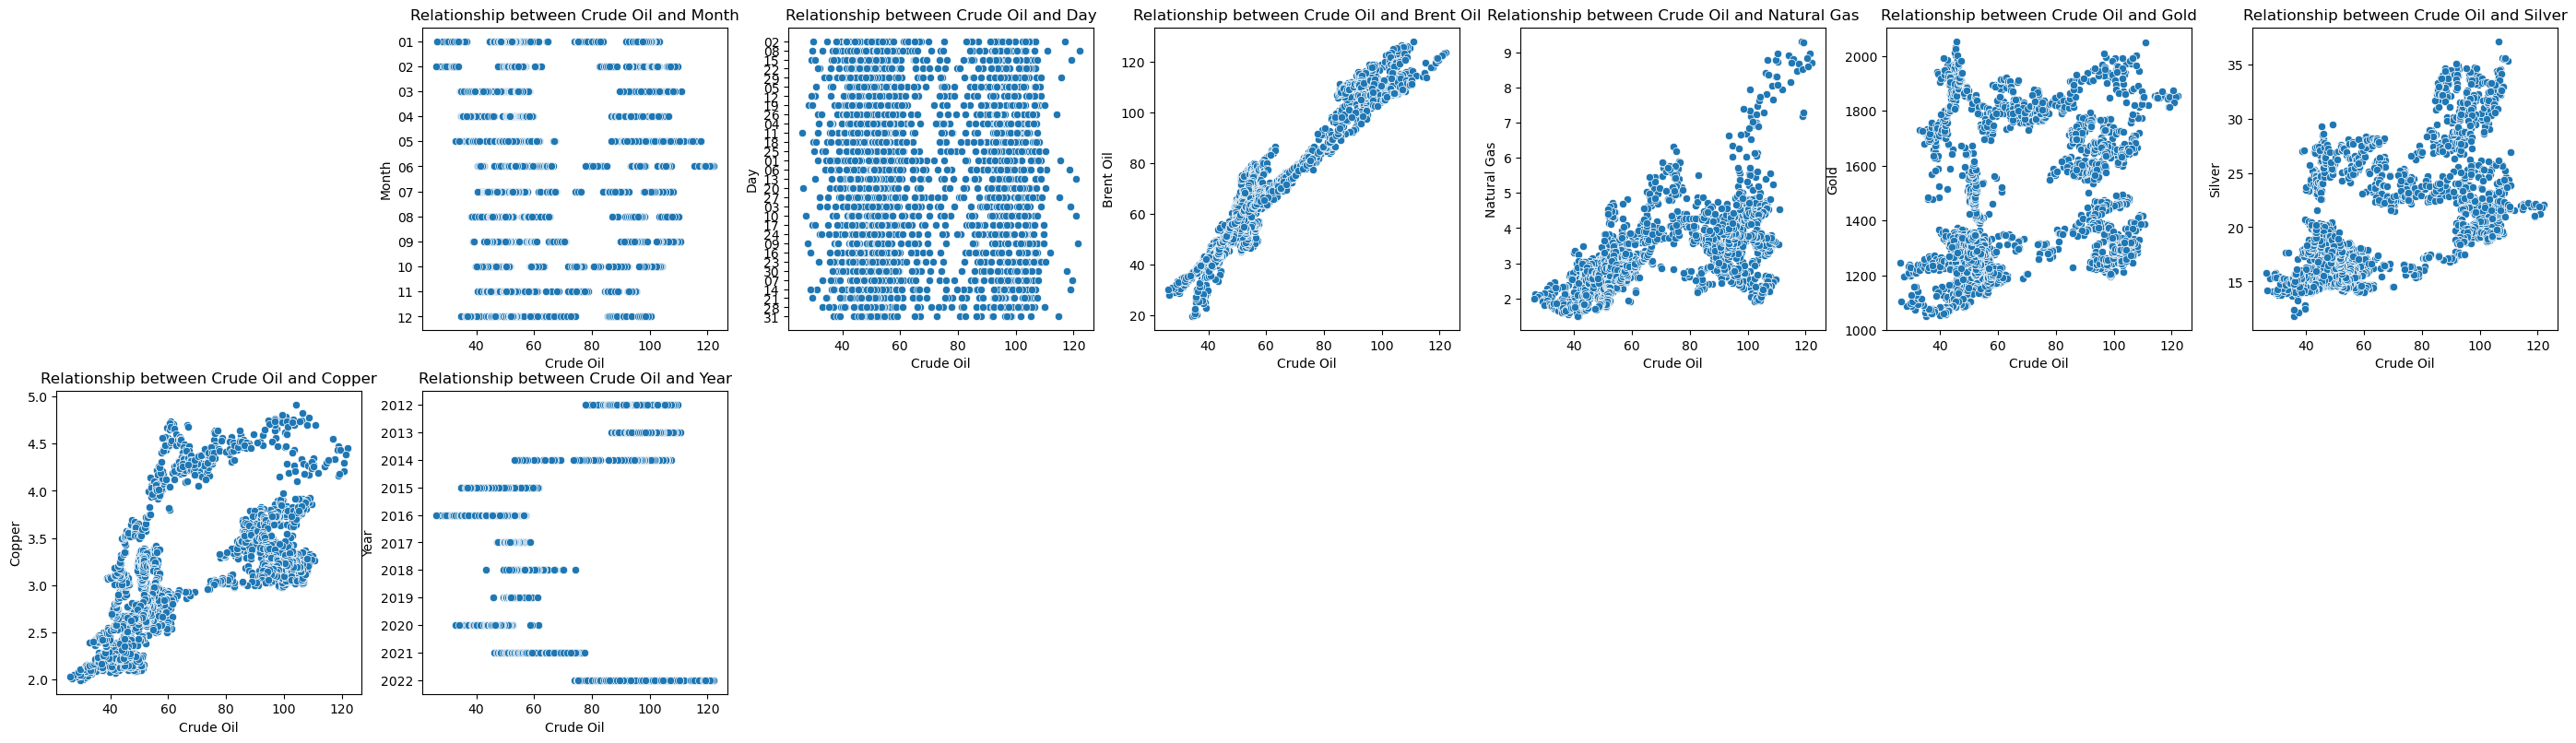

In [81]:
plt.figure(figsize=(35,35))
j=0

for i in enumerate(df): 
    if i[1]!="Crude Oil" and i[1]!="Date":
        j+=1
#         print(i[0])
#         plt.figure(figsize=(10,10))
        plt.subplot(7,7,j+1)
        sns.scatterplot(y=df[i[1]],x=df["Crude Oil"])
        plt.title('Relationship between Crude Oil and '+str(i[1]))

### Model Predictions - Gold

In [86]:
#Forecasting Gold
df_Gold=df[['Date','Gold']]
df_Gold.head()

Date  Gold
3258 2012-01-02   NaN
3257 2012-01-08   NaN
3256 2012-01-15   NaN
3255 2012-01-22   NaN
3254 2012-01-29   NaN

In [88]:
df_Gold=df_Gold.dropna()

In [90]:
prediction_days = 365
df_train_g= df_Gold['Gold'][:len(df_Gold['Gold'])-prediction_days].values.reshape(-1,1)
df_test_g= df_Gold['Gold'][len(df_Gold['Gold'])-prediction_days:].values.reshape(-1,1)

scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train_g)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test_g)

In [92]:
def create_dataset(dataset, look_back=30):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

trainX, trainY = create_dataset(scaled_train)
testX, testY = create_dataset(scaled_test)

In [94]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [130]:
def root_mean_squared_error(y_true, y_pred):
        return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true))) 
    
def model_builder(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32), return_sequences=True, input_shape= ( trainX.shape[1], trainX.shape[2]), bias_regularizer = L1L2(0.009, 0.004)))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.05)))
    model.add(Dense(1, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
   
    model.compile(loss=root_mean_squared_error, optimizer='adam',metrics = ['mse'])
    
    return model

tuner = kt.RandomSearch(model_builder, objective='val_loss', max_trials = 10, executions_per_trial =1)

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', # Monitor the validation loss
                                                     min_delta=0,    # until it doesn't change (or gets worse)
                                                     patience=5,  # patience > 1 so it continutes if it is not consistently improving
                                                     verbose=0, 
                                                     mode='auto')]

tuner.search(x=trainX, y=trainY, epochs = 200, batch_size =512, validation_data=(testX, testY), callbacks=callbacks,shuffle = True)

Trial 10 Complete [00h 02m 29s]
val_loss: 0.4577752351760864

Best val_loss So Far: 0.25653427839279175
Total elapsed time: 18h 31m 53s


In [132]:
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 08 summary
Hyperparameters:
input_unit: 64
n_layers: 1
lstm_0_units: 128
Dropout_rate: 0.35000000000000003
dense_activation: relu
lstm_1_units: 128
lstm_2_units: 384
lstm_3_units: 64
Score: 0.25653427839279175

Trial 09 summary
Hyperparameters:
input_unit: 256
n_layers: 3
lstm_0_units: 288
Dropout_rate: 0.4
dense_activation: relu
lstm_1_units: 512
lstm_2_units: 416
lstm_3_units: 288
Score: 0.4577752351760864

Trial 04 summary
Hyperparameters:
input_unit: 256
n_layers: 4
lstm_0_units: 128
Dropout_rate: 0.25
dense_activation: sigmoid
lstm_1_units: 416
lstm_2_units: 416
lstm_3_units: 32
Score: 0.4578760266304016

Trial 05 summary
Hyperparameters:
input_unit: 352
n_layers: 3
lstm_0_units: 288
Dropout_rate: 0.15000000000000002
dense_activation: sigmoid
lstm_1_units: 96
lstm_2_units: 288
lstm_3_units: 416
Score: 0.557703971862793

Trial 07 summary
Hyperparameters:
input_uni

In [134]:
best_model = tuner.get_best_models(num_models=1)[0]

C:\Users\RyanMcKiernan\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

C:\Users\RyanMcKiernan\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 



In [136]:
history = best_model.fit(x=trainX, y=trainY, epochs = 150, batch_size =128, validation_data=(testX, testY), shuffle=False, verbose=0)

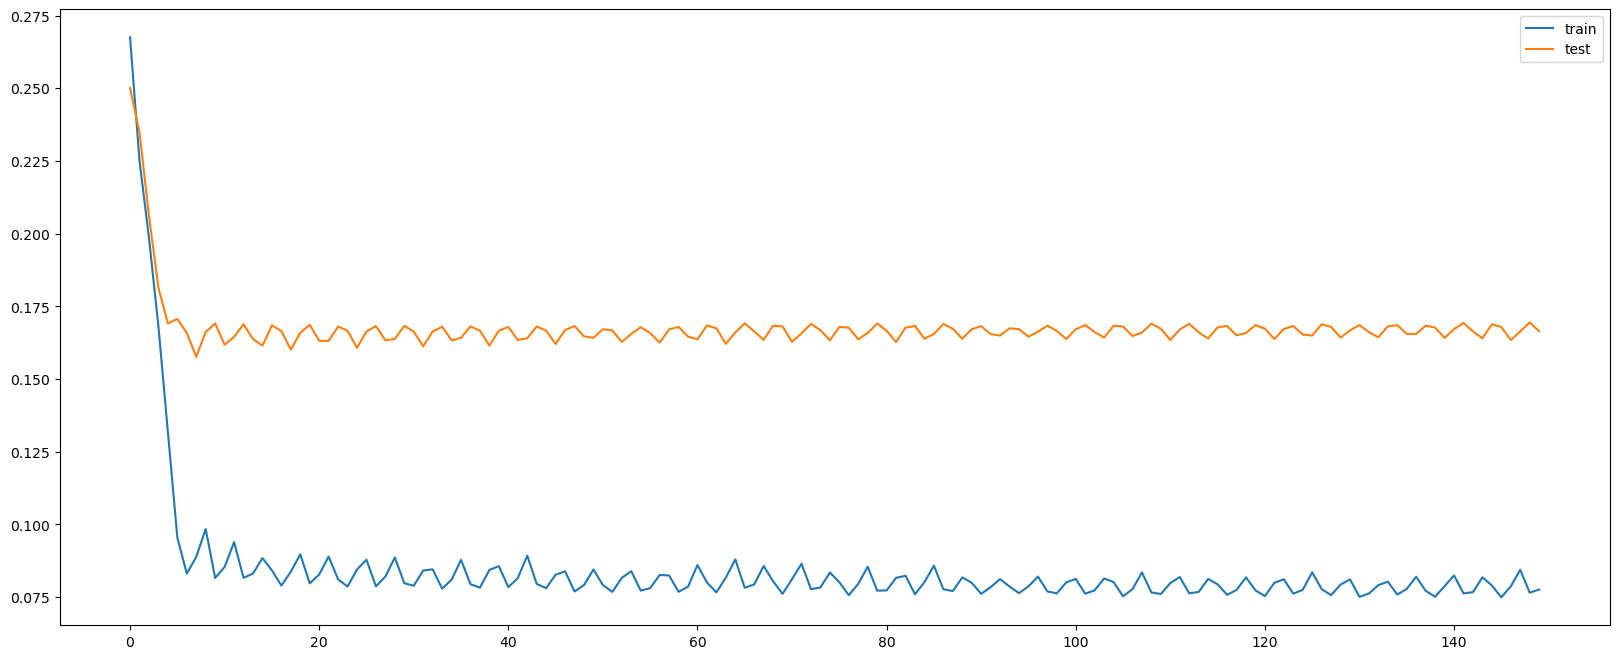

In [138]:
#Loss vs validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [140]:
predicted_gold_price = best_model.predict(testX)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


In [142]:
predicted_gold_price = scaler_test.inverse_transform(predicted_gold_price.reshape(-1, 1))
true = scaler_test.inverse_transform(testY.reshape(-1, 1))

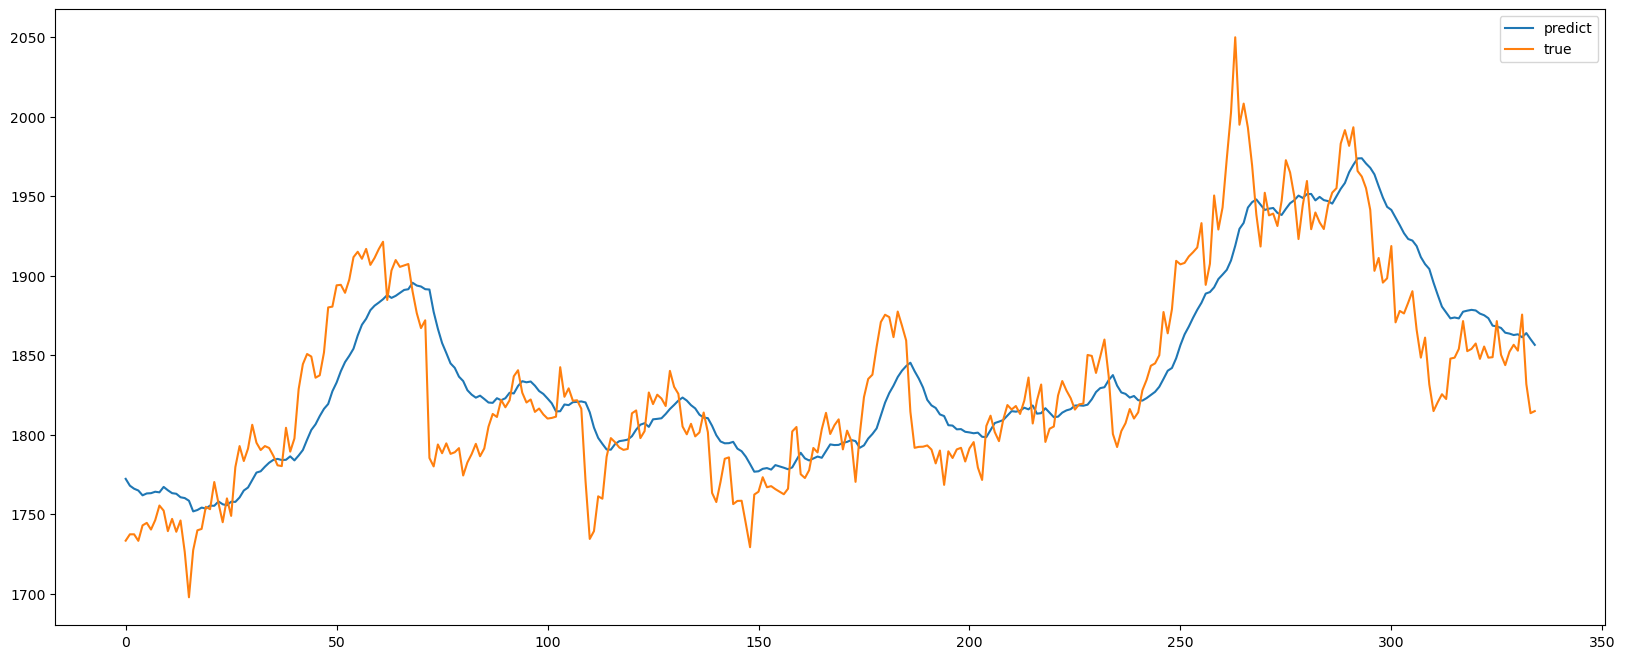

In [144]:
plt.plot(predicted_gold_price, label='predict')
plt.plot(true, label='true')
plt.legend()
plt.show()

In [146]:
gold_scores = best_model.evaluate(trainX, trainY, verbose=0)
print("%s: %.2f%%" % (best_model.metrics_names[1], gold_scores[1]*100))

compile_metrics: 0.21%


In [150]:
model_g = best_model
model_g.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 64)          │        24,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 128)         │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1, 1)           │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,797 (1.41 MB)

 Trainable params: 123,265 (481.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 246,532 (963.02 KB)

### Model Predictions - Silver

In [152]:
df_Silver=df[['Date','Silver']]

df_Silver=df_Silver.dropna()

prediction_days = 365
df_train_S= df_Silver['Silver'][:len(df_Silver['Silver'])-prediction_days].values.reshape(-1,1)
df_test_S= df_Silver['Silver'][len(df_Silver['Silver'])-prediction_days:].values.reshape(-1,1)

scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train_S)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test_S)

In [154]:
trainX=[]
trainY=[]

trainX, trainY = create_dataset(scaled_train)
testX, testY = create_dataset(scaled_test)

In [156]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [178]:
tuner_S = kt.RandomSearch(model_builder, objective='val_loss', max_trials = 10, executions_per_trial =1,project_name='Silver')

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                     min_delta=0,    
                                                     patience=5,  
                                                     verbose=0, 
                                                     mode='auto')]

tuner_S.search(x=trainX, y=trainY, epochs = 200, batch_size =512, validation_data=(testX, testY), callbacks=callbacks,shuffle = True)

Trial 10 Complete [00h 02m 11s]
val_loss: 0.2322842925786972

Best val_loss So Far: 0.23172733187675476
Total elapsed time: 00h 12m 53s


In [180]:
tuner_S.results_summary()

Results summary
Results in .\Silver
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 01 summary
Hyperparameters:
input_unit: 256
n_layers: 1
lstm_0_units: 512
Dropout_rate: 0.35000000000000003
dense_activation: sigmoid
lstm_1_units: 32
Score: 0.23172733187675476

Trial 06 summary
Hyperparameters:
input_unit: 64
n_layers: 2
lstm_0_units: 32
Dropout_rate: 0.0
dense_activation: relu
lstm_1_units: 448
lstm_2_units: 64
lstm_3_units: 224
Score: 0.23216336965560913

Trial 05 summary
Hyperparameters:
input_unit: 64
n_layers: 2
lstm_0_units: 96
Dropout_rate: 0.1
dense_activation: sigmoid
lstm_1_units: 288
lstm_2_units: 320
lstm_3_units: 224
Score: 0.23226389288902283

Trial 09 summary
Hyperparameters:
input_unit: 96
n_layers: 3
lstm_0_units: 512
Dropout_rate: 0.1
dense_activation: sigmoid
lstm_1_units: 128
lstm_2_units: 512
lstm_3_units: 448
Score: 0.2322842925786972

Trial 04 summary
Hyperparameters:
input_unit: 448
n_layers: 4
lstm_0_units: 160
Dropout_rate: 0.0
dense

In [182]:
best_model_S = tuner_S.get_best_models(num_models=1)[0]

C:\Users\RyanMcKiernan\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

C:\Users\RyanMcKiernan\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 



In [184]:
history_S = best_model_S.fit(x=trainX, y=trainY, epochs = 150, batch_size =128, validation_data=(testX, testY), shuffle=False, verbose=0)

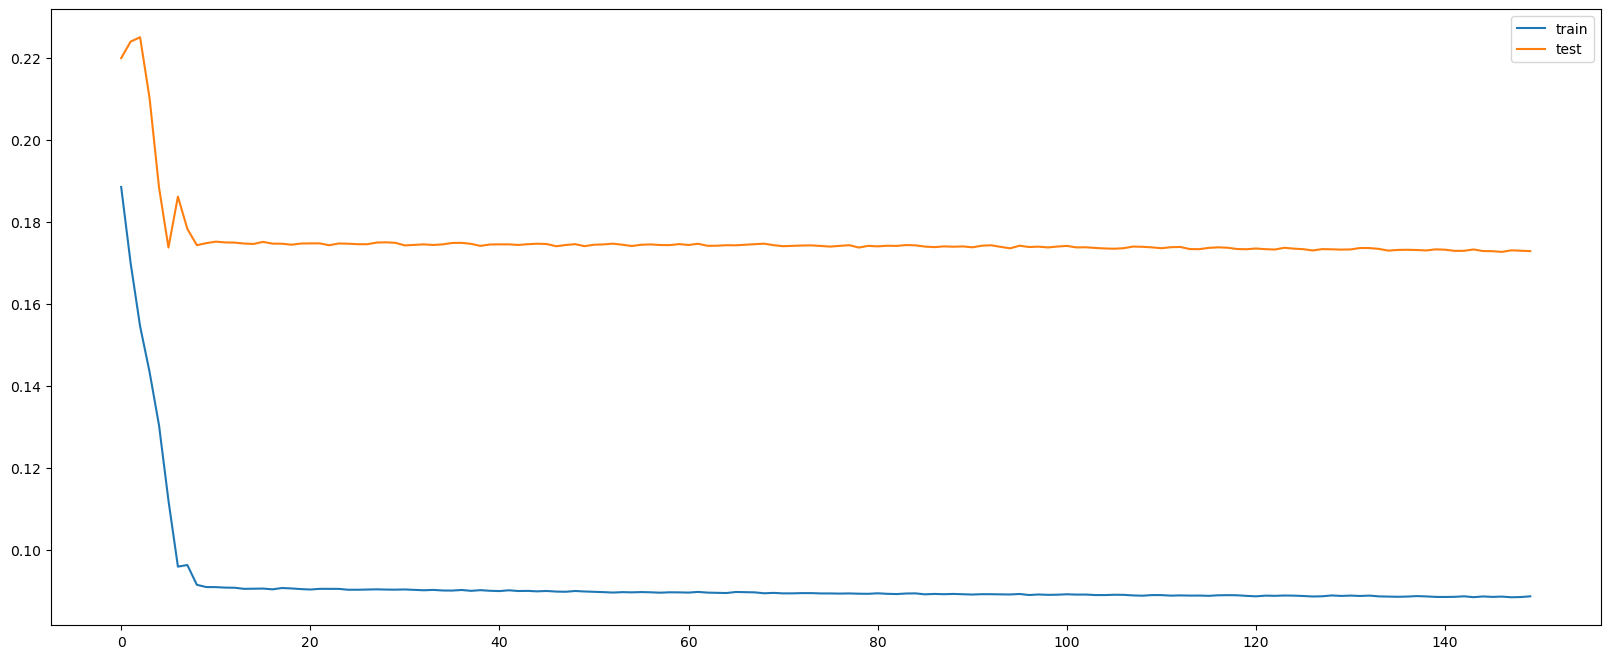

In [186]:
plt.plot(history_S.history['loss'], label='train')
plt.plot(history_S.history['val_loss'], label='test')
plt.legend()
plt.show()

In [188]:
predicted_silver_price = best_model_S.predict(testX)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


In [190]:
predicted_silver_price = scaler_test.inverse_transform(predicted_silver_price.reshape(-1, 1))
true = scaler_test.inverse_transform(testY.reshape(-1, 1))

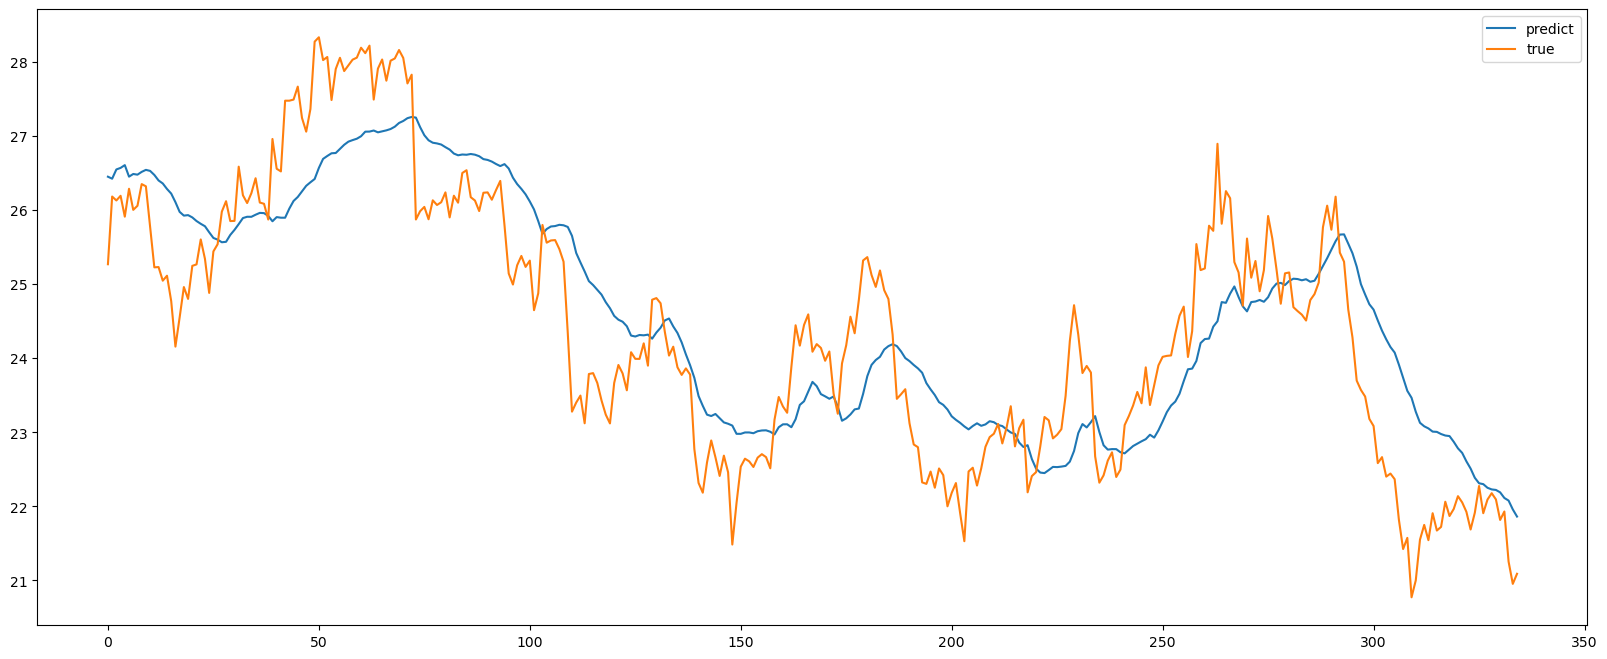

In [192]:
plt.plot(predicted_silver_price, label='predict')
plt.plot(true, label='true')
plt.legend()
plt.show()

In [194]:
silver_scores = best_model_S.evaluate(trainX, trainY, verbose=0)
print("%s: %.2f%%" % (best_model_S.metrics_names[1], silver_scores[1]*100))

compile_metrics: 0.44%


In [196]:
best_model_S.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 256)         │       293,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 512)         │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1, 1)           │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,607,941 (21.39 MB)

 Trainable params: 1,869,313 (7.13 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,738,628 (14.26 MB)

### Model Predictions - Copper

In [201]:
df_Copper=df[['Date','Copper']]

df_Copper=df_Copper.dropna()

prediction_days = 365
df_train_Co= df_Copper['Copper'][:len(df_Copper['Copper'])-prediction_days].values.reshape(-1,1)
df_test_Co= df_Copper['Copper'][len(df_Copper['Copper'])-prediction_days:].values.reshape(-1,1)

scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train_Co)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test_Co)

trainX, trainY = create_dataset(scaled_train)
testX, testY = create_dataset(scaled_test)

In [203]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [205]:
tuner_C = kt.RandomSearch(model_builder, objective='val_loss', max_trials = 10, executions_per_trial =1,project_name='Copper')

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                     min_delta=0,    
                                                     patience=5,  
                                                     verbose=0, 
                                                     mode='auto')]

tuner_C.search(x=trainX, y=trainY, epochs = 200, batch_size =512, validation_data=(testX, testY), callbacks=callbacks,shuffle = True)

Trial 10 Complete [00h 02m 56s]
val_loss: 1.1785744428634644

Best val_loss So Far: 0.5737779140472412
Total elapsed time: 00h 11m 50s


In [207]:
tuner_C.results_summary()

Results summary
Results in .\Copper
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 03 summary
Hyperparameters:
input_unit: 32
n_layers: 4
lstm_0_units: 480
Dropout_rate: 0.15000000000000002
dense_activation: relu
lstm_1_units: 512
lstm_2_units: 256
lstm_3_units: 320
Score: 0.5737779140472412

Trial 00 summary
Hyperparameters:
input_unit: 32
n_layers: 2
lstm_0_units: 128
Dropout_rate: 0.15000000000000002
dense_activation: sigmoid
lstm_1_units: 32
Score: 0.6059302687644958

Trial 07 summary
Hyperparameters:
input_unit: 288
n_layers: 1
lstm_0_units: 256
Dropout_rate: 0.05
dense_activation: sigmoid
lstm_1_units: 256
lstm_2_units: 288
lstm_3_units: 384
Score: 0.6227469444274902

Trial 02 summary
Hyperparameters:
input_unit: 320
n_layers: 1
lstm_0_units: 160
Dropout_rate: 0.05
dense_activation: sigmoid
lstm_1_units: 160
lstm_2_units: 512
lstm_3_units: 160
Score: 0.6500180959701538

Trial 06 summary
Hyperparameters:
input_unit: 352
n_layers: 3
lstm_0_units: 384
Drop

In [209]:
best_model_C = tuner_C.get_best_models(num_models=1)[0]

C:\Users\RyanMcKiernan\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

C:\Users\RyanMcKiernan\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 36 variables. 



In [211]:
history_C = best_model_C.fit(x=trainX, y=trainY, epochs = 150, batch_size =128, validation_data=(testX, testY), shuffle=False, verbose=0)

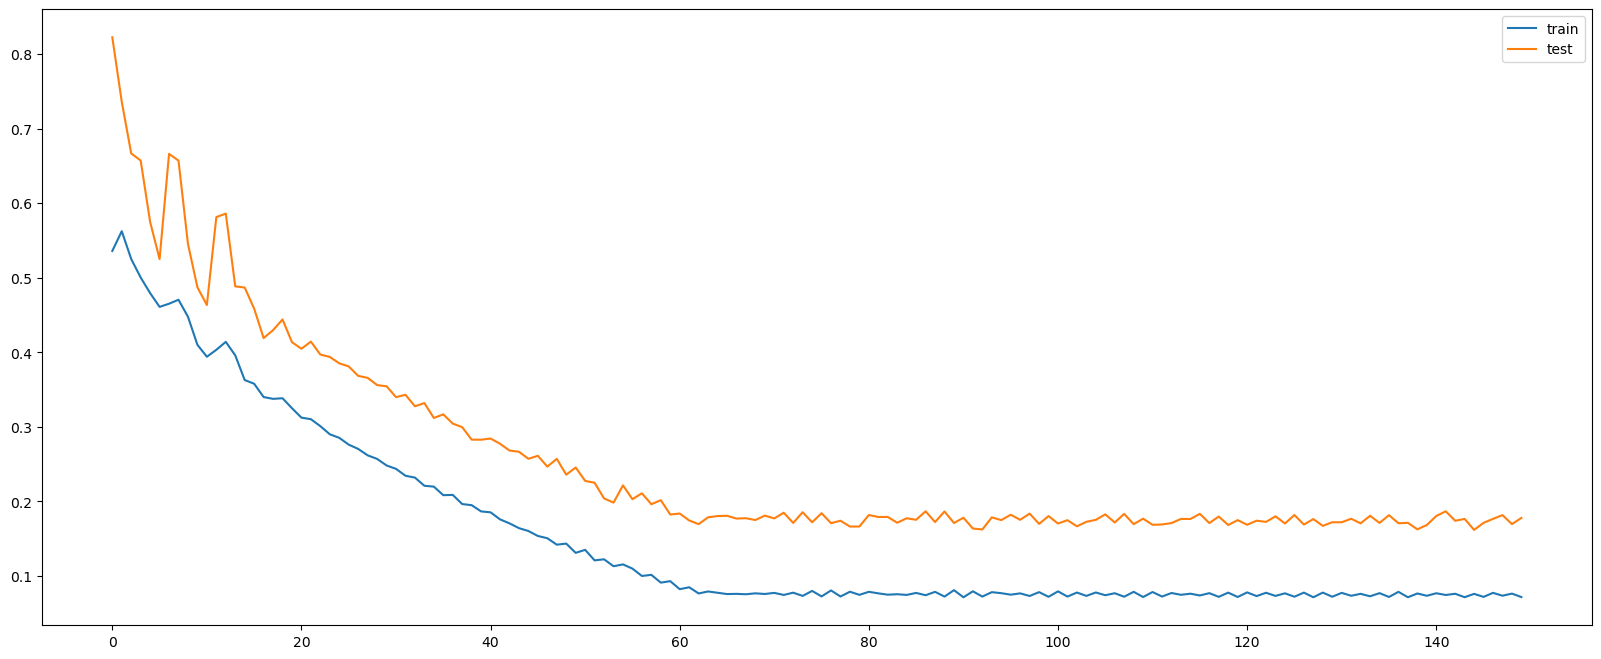

In [213]:
plt.plot(history_C.history['loss'], label='train')
plt.plot(history_C.history['val_loss'], label='test')
plt.legend()
plt.show()

In [215]:
predicted_copper_price = best_model_C.predict(testX)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step


In [217]:
predicted_copper_price = scaler_test.inverse_transform(predicted_copper_price.reshape(-1, 1))
true = scaler_test.inverse_transform(testY.reshape(-1, 1))

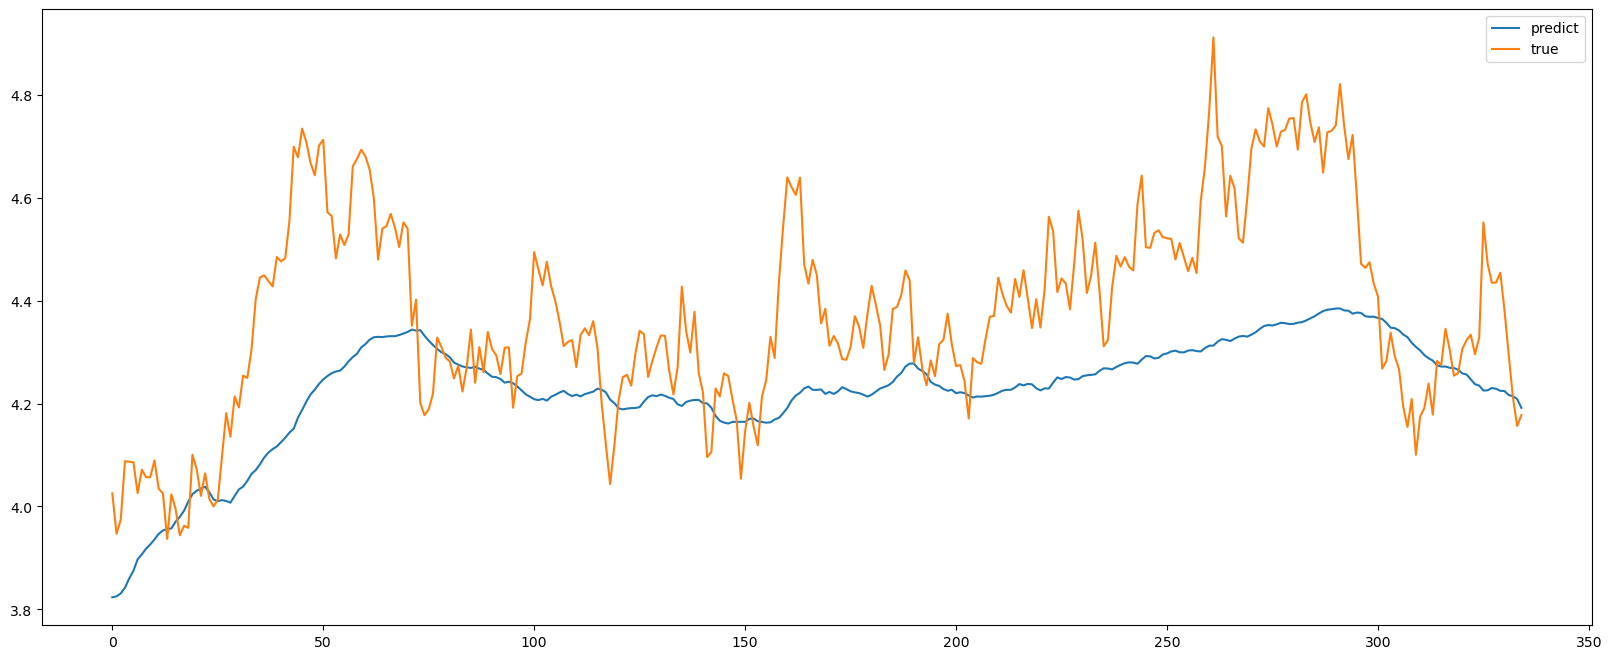

In [219]:
plt.plot(predicted_copper_price, label='predict')
plt.plot(true, label='true')
plt.legend()
plt.show()

In [221]:
copper_scores = best_model_C.evaluate(trainX, trainY, verbose=0)
print("%s: %.2f%%" % (best_model_C.metrics_names[1], copper_scores[1]*100))

compile_metrics: 0.32%


In [223]:
best_model_C.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 32)          │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 480)         │       984,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 512)         │     2,033,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 1, 256)         │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 1, 320)         │       738,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 320)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1, 1)           │           321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,659,077 (52.11 MB)

 Trainable params: 4,553,025 (17.37 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,106,052 (34.74 MB)

### Model Predictions - Crude Oil

In [226]:
df_Crude=df[['Date','Crude Oil']]
df_Crude=df_Crude.dropna()

df_train_Cr= df_Crude['Crude Oil'][:len(df_Crude['Crude Oil'])-prediction_days].values.reshape(-1,1)
df_test_Cr= df_Crude['Crude Oil'][len(df_Crude['Crude Oil'])-prediction_days:].values.reshape(-1,1)

scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train_Cr)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test_Cr)

In [228]:
trainX, trainY = create_dataset(scaled_train)
testX, testY = create_dataset(scaled_test)

In [230]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [232]:
tuner_O = kt.RandomSearch(model_builder, objective='val_loss', max_trials = 10, executions_per_trial =1,project_name='Crude Oil')

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                     min_delta=0,    
                                                     patience=5,  
                                                     verbose=0, 
                                                     mode='auto')]

tuner_O.search(x=trainX, y=trainY, epochs = 200, batch_size =512, validation_data=(testX, testY), callbacks=callbacks,shuffle = True)

Trial 10 Complete [00h 00m 46s]
val_loss: 0.48389932513237

Best val_loss So Far: 0.28049713373184204
Total elapsed time: 00h 15m 20s


In [234]:
tuner_O.results_summary()

Results summary
Results in .\Crude Oil
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 01 summary
Hyperparameters:
input_unit: 32
n_layers: 1
lstm_0_units: 512
Dropout_rate: 0.45
dense_activation: sigmoid
lstm_1_units: 288
Score: 0.28049713373184204

Trial 02 summary
Hyperparameters:
input_unit: 32
n_layers: 2
lstm_0_units: 288
Dropout_rate: 0.05
dense_activation: sigmoid
lstm_1_units: 32
Score: 0.2806995213031769

Trial 05 summary
Hyperparameters:
input_unit: 64
n_layers: 1
lstm_0_units: 512
Dropout_rate: 0.30000000000000004
dense_activation: relu
lstm_1_units: 160
lstm_2_units: 416
lstm_3_units: 224
Score: 0.31368762254714966

Trial 08 summary
Hyperparameters:
input_unit: 96
n_layers: 4
lstm_0_units: 224
Dropout_rate: 0.05
dense_activation: sigmoid
lstm_1_units: 384
lstm_2_units: 512
lstm_3_units: 128
Score: 0.3478161096572876

Trial 00 summary
Hyperparameters:
input_unit: 192
n_layers: 2
lstm_0_units: 448
Dropout_rate: 0.30000000000000004
dense_activation: 

In [236]:
best_model_O = tuner_O.get_best_models(num_models=1)[0]

C:\Users\RyanMcKiernan\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

C:\Users\RyanMcKiernan\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 



In [238]:
history_O = best_model_O.fit(x=trainX, y=trainY, epochs = 150, batch_size =128, validation_data=(testX, testY), shuffle=False, verbose=0)

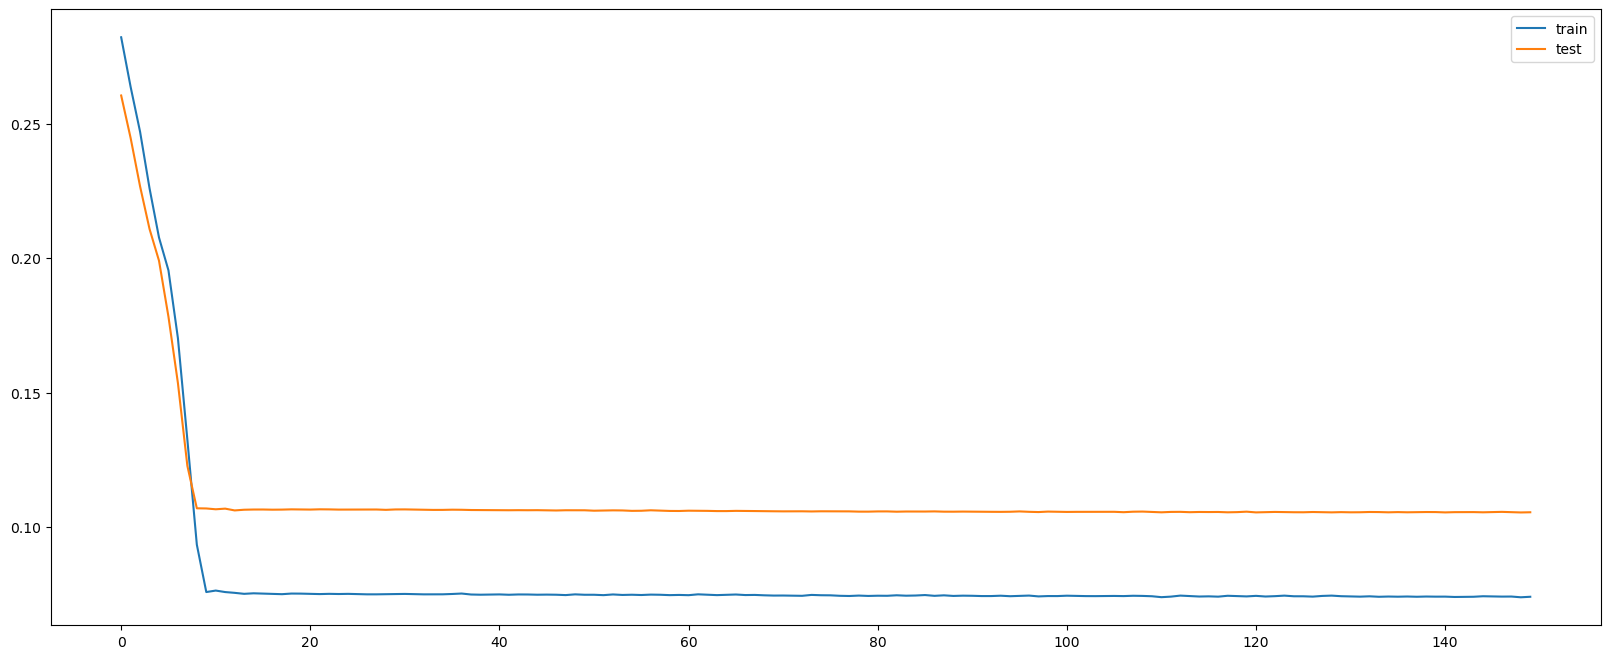

In [240]:
plt.plot(history_O.history['loss'], label='train')
plt.plot(history_O.history['val_loss'], label='test')
plt.legend()
plt.show()

In [242]:
predicted_crude_price = best_model_O.predict(testX)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


In [244]:
predicted_crude_price = scaler_test.inverse_transform(predicted_crude_price.reshape(-1, 1))
true = scaler_test.inverse_transform(testY.reshape(-1, 1))

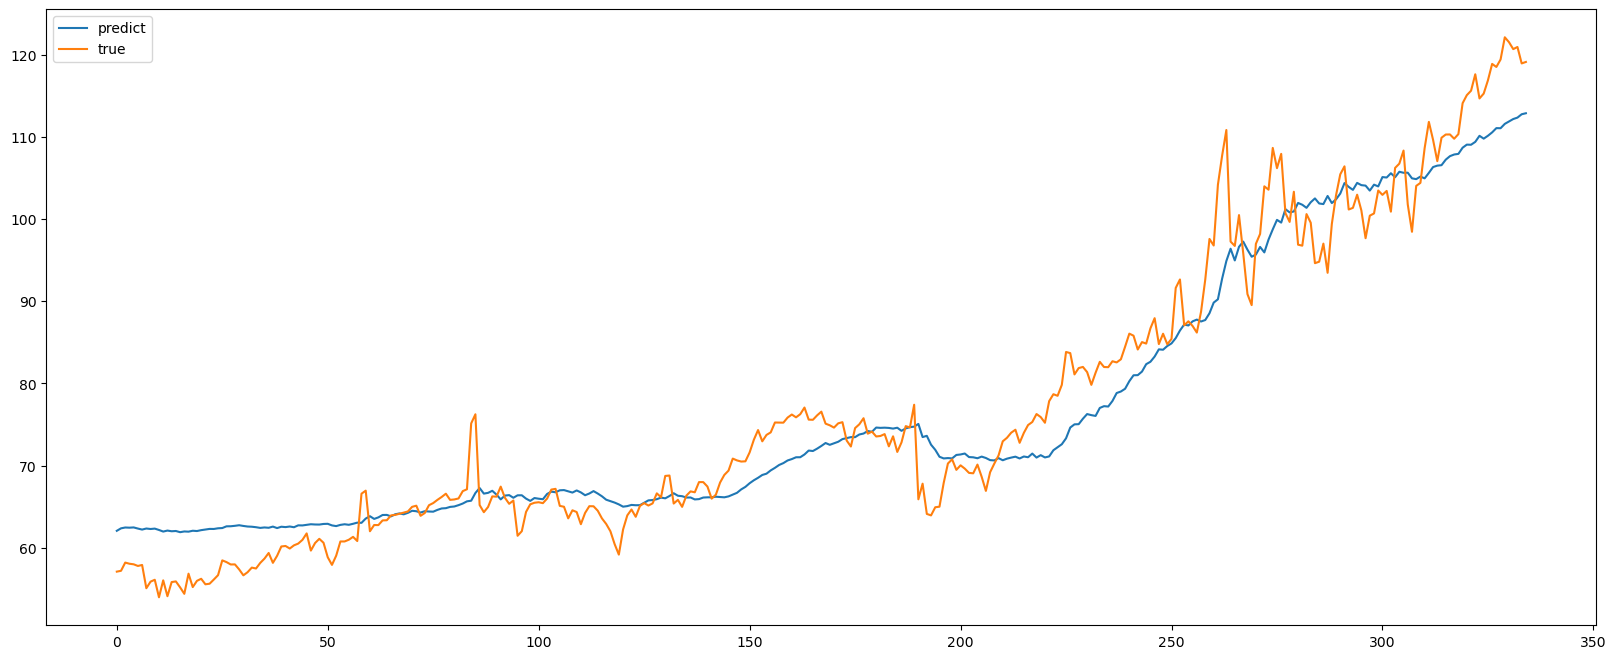

In [246]:
plt.plot(predicted_crude_price, label='predict')
plt.plot(true, label='true')
plt.legend()
plt.show()

In [248]:
crude_scores = best_model_O.evaluate(trainX, trainY, verbose=0)
print("%s: %.2f%%" % (best_model_O.metrics_names[1], crude_scores[1]*100))

compile_metrics: 0.30%


In [250]:
best_model_O.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 32)          │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 512)         │     1,116,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1, 1)           │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,374,213 (12.87 MB)

 Trainable params: 1,124,737 (4.29 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,249,476 (8.58 MB)

### Model Predictions - Brent Oil

In [253]:
df_Brent=df[['Date','Brent Oil']]

df_Brent=df_Brent.dropna()

df_train_B= df_Brent['Brent Oil'][:len(df_Brent['Brent Oil'])-prediction_days].values.reshape(-1,1)
df_test_B= df_Brent['Brent Oil'][len(df_Brent['Brent Oil'])-prediction_days:].values.reshape(-1,1)

scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train_B)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test_B)

trainX, trainY = create_dataset(scaled_train)
testX, testY = create_dataset(scaled_test)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [255]:
tuner_B = kt.RandomSearch(model_builder, objective='val_loss', max_trials = 10, executions_per_trial =1,project_name='Brent Oil')

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                     min_delta=0,    
                                                     patience=5,  
                                                     verbose=0, 
                                                     mode='auto')]

tuner_B.search(x=trainX, y=trainY, epochs = 200, batch_size =512, validation_data=(testX, testY), callbacks=callbacks,shuffle = True)

Trial 10 Complete [00h 02m 32s]
val_loss: 0.6576204299926758

Best val_loss So Far: 0.35252827405929565
Total elapsed time: 00h 15m 03s


In [257]:
tuner_B.results_summary()

Results summary
Results in .\Brent Oil
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 00 summary
Hyperparameters:
input_unit: 96
n_layers: 1
lstm_0_units: 448
Dropout_rate: 0.30000000000000004
dense_activation: sigmoid
Score: 0.35252827405929565

Trial 06 summary
Hyperparameters:
input_unit: 128
n_layers: 2
lstm_0_units: 320
Dropout_rate: 0.05
dense_activation: relu
lstm_1_units: 448
lstm_2_units: 256
Score: 0.3853236734867096

Trial 05 summary
Hyperparameters:
input_unit: 256
n_layers: 1
lstm_0_units: 320
Dropout_rate: 0.05
dense_activation: relu
lstm_1_units: 64
lstm_2_units: 64
Score: 0.5224143266677856

Trial 03 summary
Hyperparameters:
input_unit: 352
n_layers: 3
lstm_0_units: 512
Dropout_rate: 0.1
dense_activation: sigmoid
lstm_1_units: 192
lstm_2_units: 384
Score: 0.6223790645599365

Trial 07 summary
Hyperparameters:
input_unit: 352
n_layers: 2
lstm_0_units: 64
Dropout_rate: 0.45
dense_activation: relu
lstm_1_units: 384
lstm_2_units: 416
Score: 0.62457

In [259]:
best_model_B = tuner_B.get_best_models(num_models=1)[0]

C:\Users\RyanMcKiernan\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

C:\Users\RyanMcKiernan\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 



In [261]:
history_B = best_model_B.fit(x=trainX, y=trainY, epochs = 150, batch_size =128, validation_data=(testX, testY), shuffle=False, verbose=0)

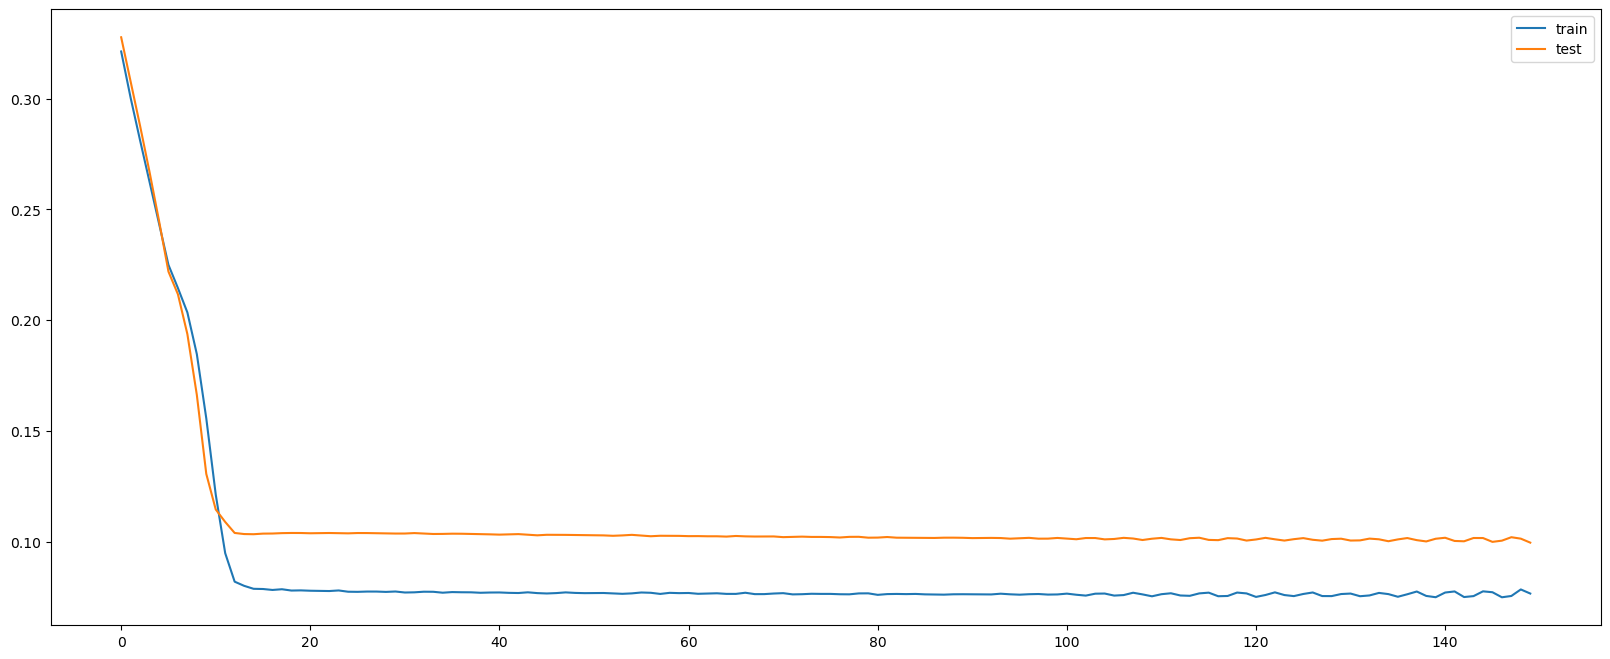

In [263]:
plt.plot(history_B.history['loss'], label='train')
plt.plot(history_B.history['val_loss'], label='test')
plt.legend()
plt.show()

In [265]:
predicted_brent_price = best_model_B.predict(testX)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


In [267]:
predicted_brent_price = scaler_test.inverse_transform(predicted_brent_price.reshape(-1, 1))
true = scaler_test.inverse_transform(testY.reshape(-1, 1))

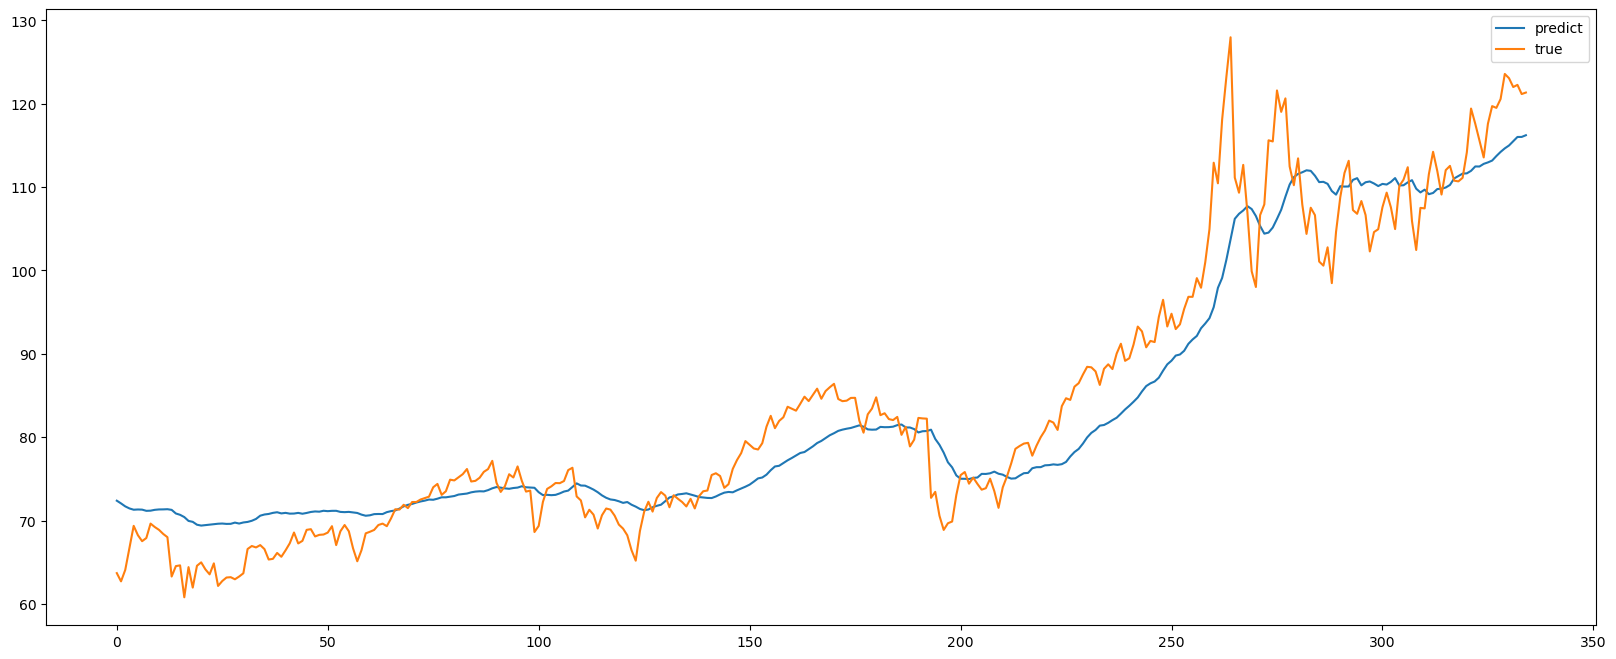

In [269]:
plt.plot(predicted_brent_price, label='predict')
plt.plot(true, label='true')
plt.legend()
plt.show()

In [271]:
brent_scores = best_model_B.evaluate(trainX, trainY, verbose=0)
print("%s: %.2f%%" % (best_model_O.metrics_names[1], brent_scores[1]*100))

compile_metrics: 0.25%


In [273]:
best_model_B.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 96)          │        48,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 448)         │       976,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 448)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1, 1)           │           449 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,077,573 (11.74 MB)

 Trainable params: 1,025,857 (3.91 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,051,716 (7.83 MB)

In [275]:
### Model Predictions - Natural Gas

In [277]:
df_Natural=df[['Date','Natural Gas']]

df_Natural=df_Natural.dropna()

df_train_N= df_Natural['Natural Gas'][:len(df_Natural['Natural Gas'])-prediction_days].values.reshape(-1,1)
df_test_N= df_Natural['Natural Gas'][len(df_Natural['Natural Gas'])-prediction_days:].values.reshape(-1,1)

scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train_N)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test_N)

trainX, trainY = create_dataset(scaled_train)
testX, testY = create_dataset(scaled_test)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [281]:
tuner_N = kt.RandomSearch(model_builder, objective='val_loss', max_trials = 10, executions_per_trial =1,project_name='Natural Gas')

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                     min_delta=0,    
                                                     patience=5,  
                                                     verbose=0, 
                                                     mode='auto')]

tuner_N.search(x=trainX, y=trainY, epochs = 200, batch_size =512, validation_data=(testX, testY), callbacks=callbacks,shuffle = True)

Trial 10 Complete [00h 00m 54s]
val_loss: 0.2739887237548828

Best val_loss So Far: 0.2739887237548828
Total elapsed time: 00h 18m 20s


In [283]:
tuner_N.results_summary()

Results summary
Results in .\Natural Gas
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 09 summary
Hyperparameters:
input_unit: 32
n_layers: 1
lstm_0_units: 352
Dropout_rate: 0.4
dense_activation: relu
lstm_1_units: 96
lstm_2_units: 352
lstm_3_units: 96
Score: 0.2739887237548828

Trial 00 summary
Hyperparameters:
input_unit: 128
n_layers: 2
lstm_0_units: 352
Dropout_rate: 0.05
dense_activation: sigmoid
lstm_1_units: 32
Score: 0.3755034804344177

Trial 05 summary
Hyperparameters:
input_unit: 288
n_layers: 4
lstm_0_units: 96
Dropout_rate: 0.15000000000000002
dense_activation: relu
lstm_1_units: 224
lstm_2_units: 352
lstm_3_units: 480
Score: 0.5445302724838257

Trial 03 summary
Hyperparameters:
input_unit: 352
n_layers: 2
lstm_0_units: 512
Dropout_rate: 0.4
dense_activation: sigmoid
lstm_1_units: 160
lstm_2_units: 448
Score: 0.6122298240661621

Trial 08 summary
Hyperparameters:
input_unit: 352
n_layers: 4
lstm_0_units: 32
Dropout_rate: 0.45
dense_activation: sig

In [285]:
best_model_N = tuner_N.get_best_models(num_models=1)[0]

C:\Users\RyanMcKiernan\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

C:\Users\RyanMcKiernan\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 



In [287]:
history_N = best_model_N.fit(x=trainX, y=trainY, epochs = 150, batch_size =128, validation_data=(testX, testY), shuffle=False, verbose=0)

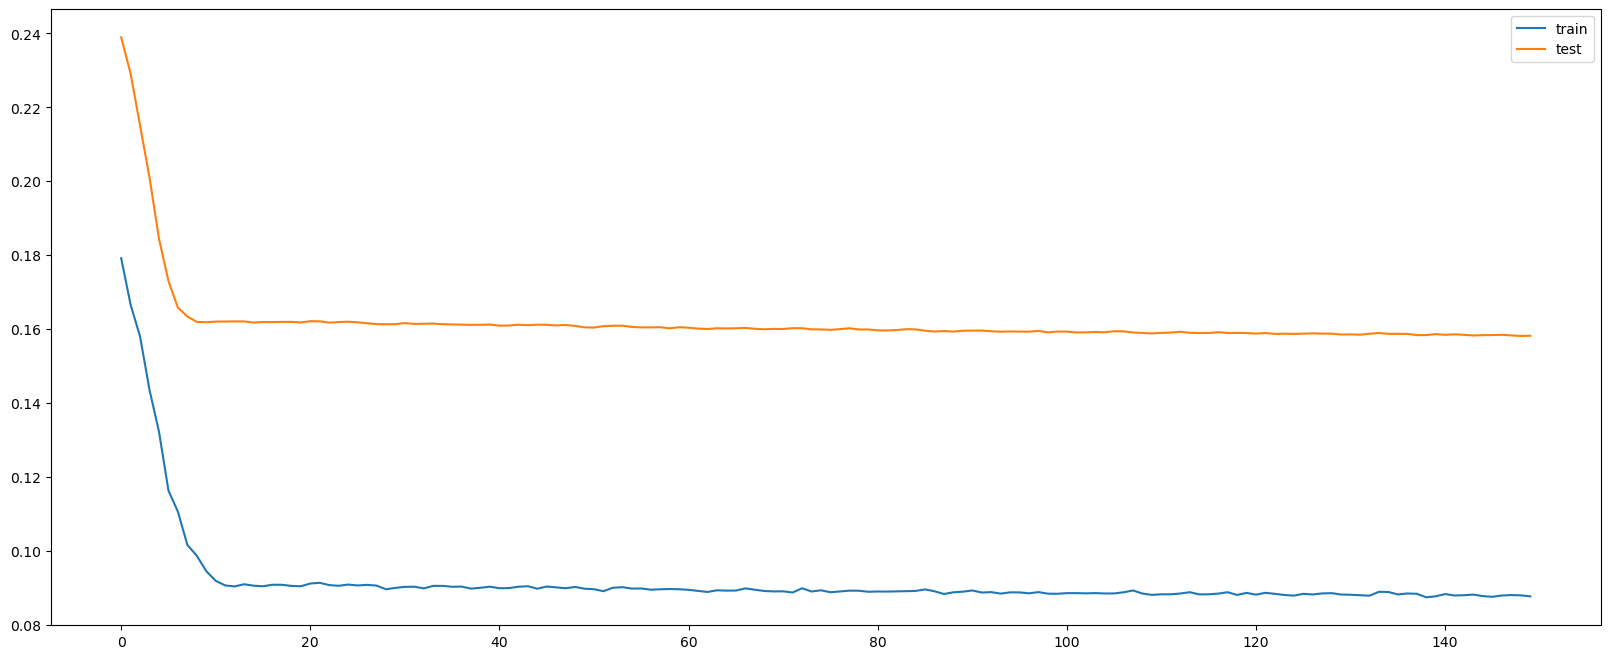

In [289]:
plt.plot(history_N.history['loss'], label='train')
plt.plot(history_N.history['val_loss'], label='test')
plt.legend()
plt.show()

In [291]:
predicted_gas_price = best_model_N.predict(testX)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


In [293]:
predicted_gas_price = scaler_test.inverse_transform(predicted_gas_price.reshape(-1, 1))
true = scaler_test.inverse_transform(testY.reshape(-1, 1))

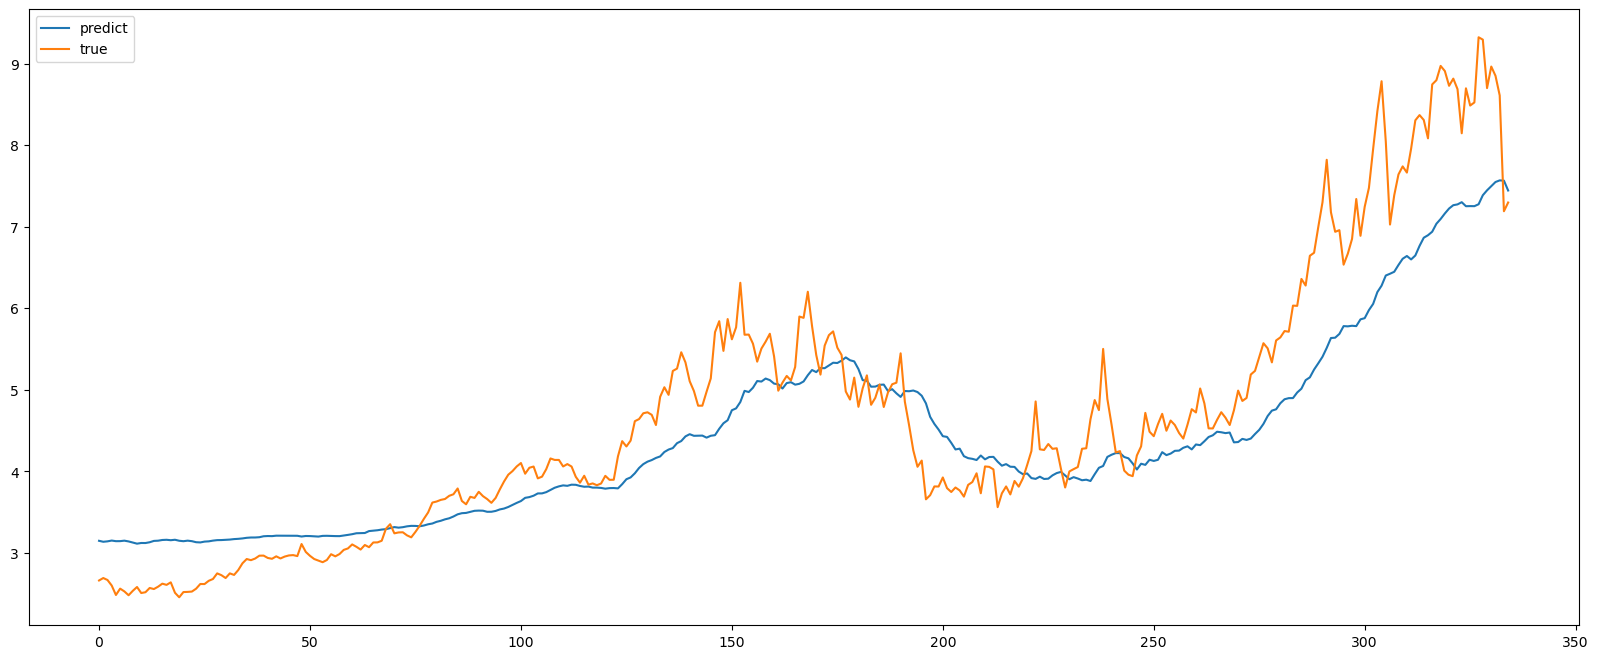

In [295]:
plt.plot(predicted_gas_price, label='predict')
plt.plot(true, label='true')
plt.legend()
plt.show()

In [297]:
gas_scores = best_model_N.evaluate(trainX, trainY, verbose=0)
print("%s: %.2f%%" % (best_model_N.metrics_names[1], gas_scores[1]*100))

compile_metrics: 0.37%


In [299]:
best_model_N.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 32)          │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 352)         │       542,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1, 1)           │           353 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,651,493 (6.30 MB)

 Trainable params: 550,497 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,100,996 (4.20 MB)

### Results
- Gold: 0.21
- Silver: 0.44
- Copper: 0.32
- Crude Oil: 0.30
- Brent Oil: 0.25
- Natural Gas: 0.37

### Trend Prediction Analysis
- Gold: The predicted line follows the general upward and downward trends of the true values fairly well, especially in periods of gradual movements.
However, sharp spikes and rapid fluctuations in the true values are not captured effectively by the model.
- Silver: The predicted values capture the overall long-term trends but lag behind in matching short-term volatility. There's a tendency for the model to produce smoother predictions compared to the more erratic true values.
- Copper: The model captures the broad trajectory of Copper prices over time but shows similar smoothing behavior.
The prediction diverges significantly during sharp price increases or decreases.
- Crude Oil and Brent Oil: The predicted values for Crude Oil and Brent Oil align well with the general upward trend, particularly in the latter half of the dataset. The predictions smooth out sharp fluctuations seen in the true values, especially during sudden spikes or dips.
- Natural Gas: The model captures the general trend but exhibits more lag and smoothing compared to the true values. This smoothing is particularly evident during sharp upward or downward movements in the price.